# **PORTFOLIO OPTIMISATION 2021**

In [1]:
import numpy as np
import pandas as pd
import math
from pandas_datareader import data
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import investpy as ipy
%matplotlib inline
import datetime as dt
import statsmodels.api as sm
from scipy import stats
from statsmodels import regression
from sklearn.linear_model import LinearRegression
#from pandas_profiling import ProfileReport
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
today = dt.datetime.today().strftime("%d/%m/%Y")
import mlportfolio

In [2]:
#pd.set_option('display.max_rows', 100)
#plt.rcParams['axes.xmargin'] = 0
scaler = MinMaxScaler()
std_scaler = StandardScaler()
rob_scaler = RobustScaler()

In [3]:
def log_rate(df):
    return np.log(df / df.shift(1)).dropna(how='all')

def ewcorr(df, span=300):
    corr = df.ewm(span=span).corr()
    return corr.loc[corr.index.levels[0][-1]]

def ewcov(df, span=300):
    cov = df.ewm(span=span).cov()
    return cov.loc[cov.index.levels[0][-1]]

def ewstd(df, span=300):
    std = df.ewm(span=span).std()
    return std.iloc[-1]

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], str(point['val']), fontweight='semibold', alpha=0.7)

def getPCA(df):
    pca = PCA(n_components=2)

    pComponents = pca.fit_transform(df)

    df_PCA = pd.DataFrame(data = pComponents, index=df.index,
                          columns = ['Principal Component 1', 'Principal Component 2'])
    return df_PCA

In [4]:
plt.style.use(['seaborn'])

In [5]:
pd.set_option("display.max_rows", 20)
#pd.set_option('display.float_format', lambda x: '%.2f' % x)

### Lists of Stocks 

Here, the most up-to-date list of Kompas 100 stocks is collected from Kontan. Kompas 100 was chosen as the stocks universe as it provides a larger dataset than LQ45 or IDX30 yet manageable enough for the computational  resource available for the research in comparison to the 600+ of stocks listed on IDX.

In [6]:
# lis = mlportfolio.index_list_kontan('KOMPAS100')
# df = lis.download()
# df.to_pickle('stocks-list.pkl')

In [7]:
df = pd.read_pickle('stocks-list.pkl')
code = df['Kode']
code_arr =[]
sym = []
for i in range(len(code)):
  sym.append(code[i])
  code_arr.append(code[i]+'.JK')

## **Data Reader**

After the list of stocks has been collected, using `yfinance` module to download the historical time series data from Yahoo Finance. The data collected for these stocks span from 1 Jan 2010 to today.

### **KOMPAS100 Stocks Prices: 2010-2021**

In [8]:
training_year ='2019'
test_year = '2020'

In [9]:
# # df1 = yf.download(code_arr, start='2010-01-01')
# # df1.info()
# df1.to_pickle('stocks-data.pkl')

In [10]:
df0 = pd.read_pickle('stocks-data.pkl')

In [11]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2948 entries, 2010-01-04 to 2021-12-13
Columns: 600 entries, ('Adj Close', 'AALI.JK') to ('Volume', 'WTON.JK')
dtypes: float64(600)
memory usage: 13.5 MB


In [12]:
data_count = df0['Adj Close'].describe().loc['count']

In [13]:
thresh=data_count.median()

<AxesSubplot:>

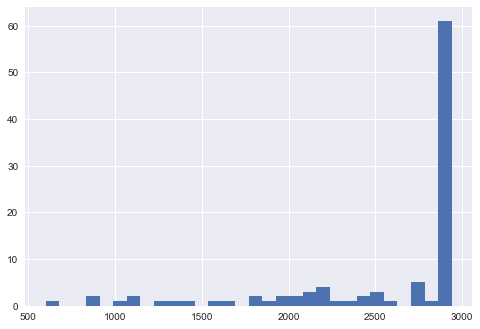

In [14]:
data_count.hist(bins=30)

In [15]:
df1 = df0.dropna(axis=1, thresh=thresh)

In [16]:
from celluloid import Camera

<AxesSubplot:xlabel='Date', ylabel='Adj Close Price'>

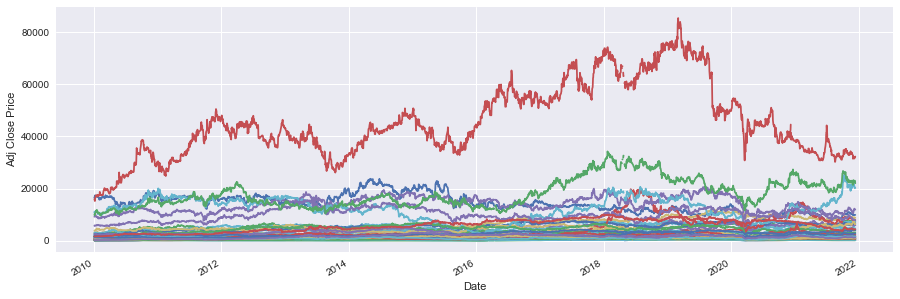

In [17]:
df1['Adj Close'].plot(legend=False, xlabel='Date', ylabel='Adj Close Price', figsize=(15,5))

In [18]:
adj_close = df1['Adj Close']

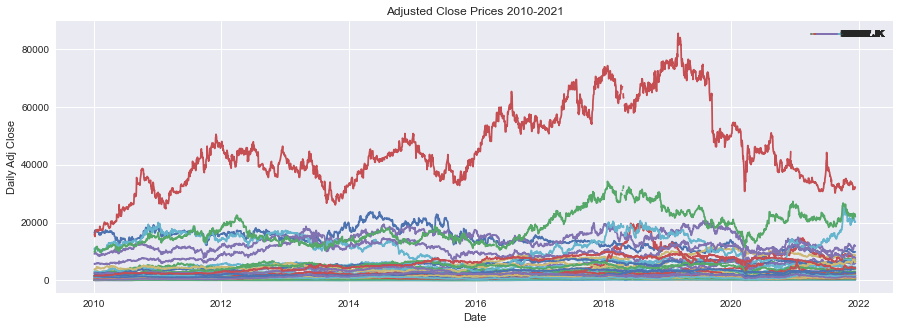

In [19]:
fig = plt.figure(figsize=[15,5])
camera = Camera(fig)
plt.xlabel('Date')
plt.ylabel('Daily Adj Close')
plt.title('Adjusted Close Prices 2010-2021')

for i in range(len(adj_close.columns)):
    data = adj_close.iloc[:, i]
    t=plt.plot(data, scaley=True)
    plt.legend(t,[data.name])
    camera.snap()

In [20]:
from IPython.display import HTML
animation = camera.animate()
animation.save('prices.gif')

In [21]:
columns=df1.columns.get_level_values(0).unique()

In [22]:
df1.groupby(level=0, axis=1).mean().describe().round(2)

,Adj Close,Close,High,Low,Open,Volume
count,2945.00,2945.00,2945.00,2945.00,2945.00,2.945000e+03
mean,4051.23,4929.55,5001.18,4859.64,4932.98,3.067864e+07
std,759.20,685.55,687.48,682.76,685.68,1.565195e+07
min,1312.52,1335.00,1335.00,1335.00,1335.00,0.000000e+00
25%,3546.16,4500.06,4580.42,4431.99,4502.73,2.195886e+07
50%,4009.96,4977.58,5052.96,4913.75,4983.60,2.730578e+07
75%,4496.56,5359.39,5420.95,5282.19,5355.99,3.493761e+07
max,6117.38,6838.59,6838.59,6838.59,6838.59,1.878984e+08


In [23]:
df1.groupby(level=0, axis=1).mean().round(2)

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2010-01-04,2219.25,3394.89,3427.35,3313.44,3359.85,17055766.65
2010-01-05,2248.67,3448.27,3473.45,3385.44,3446.54,29412161.88
2010-01-06,2245.34,3441.43,3507.69,3405.32,3438.84,31741730.48
2010-01-07,2248.64,3441.88,3499.48,3386.57,3439.67,33546109.37
2010-01-08,2284.49,3492.09,3518.48,3427.29,3492.33,23862044.17
...,...,...,...,...,...,...
2021-12-07,4366.52,4366.52,4410.96,4317.00,4360.44,29842071.15
2021-12-08,4325.35,4325.35,4408.77,4306.40,4374.88,29492005.77
2021-12-09,4340.31,4340.31,4386.10,4301.19,4339.77,24417751.92


In [24]:
adj_close

,AALI.JK,ADHI.JK,ADRO.JK,AKRA.JK,ANTM.JK,ASII.JK,ASRI.JK,BBCA.JK,BBRI.JK,BBTN.JK,...,PTBA.JK,PWON.JK,RALS.JK,SMGR.JK,SMRA.JK,TINS.JK,TLKM.JK,UNTR.JK,UNVR.JK,WIKA.JK
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,16410.125000,270.381287,1063.347290,754.387878,1601.085449,2518.653564,96.725533,855.341125,588.306885,655.905151,...,1855.615967,116.141266,448.737213,5704.010254,259.101562,1120.500000,1403.605713,9867.144531,1649.384644,247.194794
2010-01-05,16650.947266,263.786591,1087.652222,742.020874,1601.085449,2532.923584,98.567917,863.809998,592.078125,655.905151,...,1855.615967,118.374763,482.732574,5779.062988,263.647217,1146.864624,1410.954590,10118.534180,1701.627808,247.194794
2010-01-06,16582.144531,267.083893,1093.728638,735.837280,1601.085449,2518.653564,98.567917,838.403809,584.535706,726.180725,...,1897.314941,111.674309,469.134491,5854.115723,268.192841,1160.047241,1396.257080,10087.111328,1686.700806,247.194794
2010-01-07,17235.794922,270.381287,1118.033569,723.470398,1635.891724,2440.168457,99.489105,842.638184,576.993347,726.180725,...,1902.527344,110.557556,455.536346,5779.062988,268.192841,1146.864624,1359.513550,9961.415039,1656.848022,247.194794
2010-01-08,17373.404297,273.678589,1190.949097,717.286987,1635.891724,2454.438232,102.252693,821.466431,580.764526,749.605896,...,1907.739746,111.674309,448.737213,5741.537109,268.192841,1146.864624,1374.210938,10307.079102,1664.311157,243.449371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-07,9925.000000,1090.000000,1905.000000,4260.000000,2340.000000,5925.000000,171.000000,7350.000000,4230.000000,1750.000000,...,2750.000000,486.000000,695.000000,8075.000000,880.000000,1550.000000,4150.000000,23000.000000,4270.000000,1215.000000
2021-12-08,9925.000000,1085.000000,1925.000000,4290.000000,2330.000000,5800.000000,171.000000,7425.000000,4210.000000,1750.000000,...,2720.000000,488.000000,695.000000,8025.000000,875.000000,1540.000000,4090.000000,22350.000000,4270.000000,1205.000000
2021-12-09,9950.000000,1075.000000,1935.000000,4330.000000,2330.000000,6000.000000,172.000000,7350.000000,4190.000000,1750.000000,...,2720.000000,480.000000,690.000000,8025.000000,880.000000,1565.000000,4150.000000,22325.000000,4370.000000,1190.000000


In [25]:
stocks_list = adj_close.columns

### **KOMPAS 100 Index Prices: 2010-2021**

In [26]:
# df2 = ipy.indices.get_index_historical_data(index='idx kompas 100', country='Indonesia', from_date='01/01/2010', to_date= today)
# df2.info()
# df2.to_pickle('market-data.pkl')

In [27]:
df2 = pd.read_pickle('market-data.pkl')
df2.describe().round(2)

,Open,High,Low,Close,Volume
count,2926.00,2926.00,2926.00,2926.00,2.926000e+03
mean,1052.30,1058.85,1044.65,1051.93,3.858968e+09
std,172.92,172.46,172.77,172.28,3.313029e+10
min,591.86,595.92,580.38,592.09,0.000000e+00
25%,922.67,929.16,914.17,923.21,2.256659e+09
50%,1069.06,1075.26,1061.62,1068.62,2.897808e+09
75%,1193.59,1200.60,1187.73,1193.44,3.788222e+09
max,1420.94,1421.95,1406.81,1421.50,1.793415e+12


In [28]:
df2.head(10)
market_data_all = df2

<AxesSubplot:xlabel='Date'>

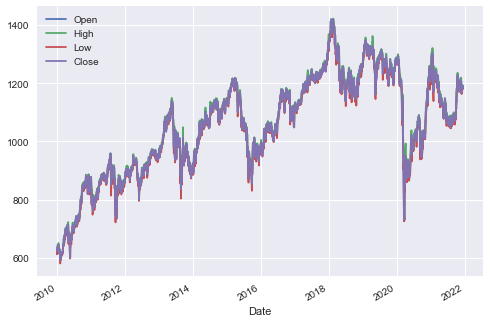

In [29]:
df2.iloc[:, :4].plot()

### **Indonesia Gov't Bond Yield 1 Year: 2010-2021**

Here, the bond yields of Indonesia's 1 Year Bond from 1 Jan 2010 to today are collected from Investing.com. 

In [30]:
# df5 = ipy.bonds.get_bond_historical_data(bond = 'INDONESIA 1Y', from_date='01/01/2010', to_date= today)
# bond_yield = df5[df5.index.isin(df2.index)].divide(100)
# bond_yield.to_pickle('bond-data.pkl')

<AxesSubplot:xlabel='Date', ylabel='Rate'>

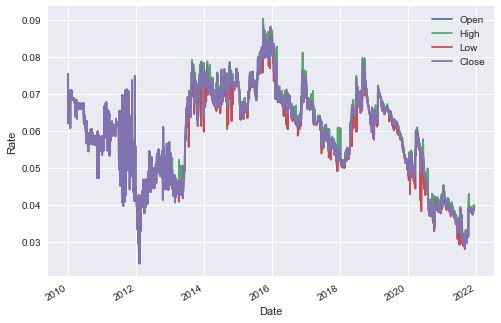

In [31]:
bond_yield = pd.read_pickle('bond-data.pkl').replace(0, method='ffill')
bond_yield.plot(ylabel='Rate')

In [32]:
bond_yield.describe().round(3)

,Open,High,Low,Close
count,2909.000,2909.000,2909.000,2909.000
mean,0.059,0.060,0.059,0.059
std,0.013,0.013,0.012,0.013
min,0.024,0.024,0.024,0.024
25%,0.050,0.051,0.050,0.050
50%,0.062,0.062,0.062,0.062
75%,0.068,0.069,0.068,0.068
max,0.090,0.090,0.089,0.089


### **Financial Summaries of KOMPAS100 Companies**

In [33]:
# info_summ = pd.DataFrame()
# fin_dict = {}

# for x in sym: 
#     info = ipy.stocks.get_stock_information(stock= x, country= 'Indonesia')
#     info_summ = info_summ.append(info)
    
#     try:
#         inc_sta = ipy.stocks.get_stock_financial_summary(stock= x, country= 'Indonesia', summary_type='income_statement')
#         fin_dict[x +'.JK']= inc_sta.sort_values(by='Date')
#     except:
#         pass

In [34]:
# fin_summ = pd.concat(fin_dict, axis=1)*1000000 #Values should be in millions IDR

# info_summ.reset_index(drop=True)
# info_summ.index = code_arr

In [35]:
# fin_summ.to_pickle('fin-summ.pkl')
# info_summ.to_pickle('info-summ.pkl')

In [36]:
info_summ = pd.read_pickle('info-summ.pkl').loc[stocks_list]
info_summ

,Stock Symbol,Prev. Close,Todays Range,Revenue,Open,52 wk Range,EPS,Volume,Market Cap,Dividend (Yield),Average Vol. (3m),P/E Ratio,Beta,1-Year Change,Shares Outstanding,Next Earnings Date
AALI.JK,AALI,8575.0,"8,475-8,600",2.056000e+13,8600.0,"7,275-13,350",566.60,645100.0,1.636000e+13,153.00(1.80%),1822292.0,15.0,1.6,-13.49%,1.924688e+09,01/11/2021
ADHI.JK,ADHI,815.0,810-830,1.527000e+13,815.0,"488-2,040",5.89,15876400.0,2.920000e+12,N/A(N/A),20883567.0,139.13,2.94,50.46%,3.560849e+09,01/11/2021
ADRO.JK,ADRO,1365.0,"1,345-1,375",3.943000e+13,1370.0,"1,090-1,600",69.83,61919000.0,4.318000e+13,65.41(4.91%),83198919.0,19.33,1.17,20.54%,3.198596e+10,02/11/2021
AKRA.JK,AKRA,3770.0,"3,730-3,770",1.648000e+13,3770.0,"2,450-3,960",264.42,1881200.0,1.476000e+13,135.00(3.58%),8070630.0,14.14,1.8,41.67%,3.947434e+09,01/11/2021
ANTM.JK,ANTM,2440.0,"2,470-2,630",3.138000e+13,2470.0,"695-3,440",85.79,423200100.0,6.224000e+13,16.74(0.65%),101072438.0,30.19,2.4,250%,2.403076e+10,22/10/2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TINS.JK,TINS,1500.0,"1,515-1,570",1.311000e+13,1520.0,"655-2,540",43.64,98472400.0,1.143000e+13,N/A(N/A),35982937.0,35.17,2.57,104.67%,7.447753e+09,09/11/2021
TLKM.JK,TLKM,3390.0,"3,320-3,390",1.390900e+14,3380.0,"2,540-3,640",224.77,52115300.0,3.298800e+14,168.01(4.96%),87192791.0,14.82,0.79,23.33%,9.906222e+10,25/10/2021
UNTR.JK,UNTR,21800.0,"21,150-21,700",6.447000e+13,21700.0,"18,525-28,475",1731.29,2663900.0,7.917000e+13,473.00(3.03%),3613248.0,12.26,0.72,-0.82%,3.730135e+09,01/11/2021
UNVR.JK,UNVR,4100.0,"4,080-4,150",4.138000e+13,4130.0,"4,010-8,325",172.73,14311100.0,1.556500e+14,187.00(4.56%),23514959.0,23.62,0.4,-48.84%,3.815000e+10,26/10/2021


In [37]:
fin_summ = pd.read_pickle('fin-summ.pkl').loc[:,stocks_list]
fin_test=fin_summ[:training_year]

In [38]:
fin_test

AALI.JK                                               \
           Total Revenue  Gross Profit Operating Income    Net Income   
Date                                                                    
2017-12-31  1.730569e+13  4.145250e+12     2.992440e+12  1.968027e+12   
2018-12-31  1.908439e+13  3.539506e+12     2.180324e+12  1.438511e+12   
2019-12-31  1.745274e+13  2.144506e+12     1.028365e+12  2.111170e+11   

                 ADHI.JK                                               \
           Total Revenue  Gross Profit Operating Income    Net Income   
Date                                                                    
2017-12-31  1.515618e+13  2.057806e+12     1.707672e+12  5.154153e+11   
2018-12-31  1.565550e+13  2.506603e+12     1.798931e+12  6.441589e+11   
2019-12-31  1.530786e+13  2.336054e+12     1.441986e+12  6.638062e+11   

                 ADRO.JK                ...          UNTR.JK                \
           Total Revenue  Gross Profit  ... Operating Income    Net Income   
Date                                    ...                                  
2017-12-31  3.258330e+09  1.141500e+09  ...     1.057159e+13  7.402966e+12   
2018-12-31  3.619750e+09  1.210210e+09  ...     1.658316e+13  1.112563e+13   
2019-12-31  3.457150e+09  9.645900e+08  ...     1.660501e+13  1.131207e+13   

                 UNVR.JK                                               \
           Total Revenue  Gross Profit Operating Income    Net Income   
Date                                                                    
2017-12-31  4.120451e+13  2.123528e+13     9.495764e+12  7.004562e+12   
2018-12-31  4.180207e+13  2.116389e+13     1.232421e+13  9.081187e+12   
2019-12-31  4.292256e+13  2.238571e+13     1.012091e+13  7.392837e+12   

                 WIKA.JK                                               
           Total Revenue  Gross Profit Operating Income    Net Income  
Date                                                                   
2017-12-31  2.617640e+13  2.876234e+12     2.804569e+12  1.202069e+12  
2018-12-31  3.115819e+13  3.604727e+12     4.367729e+12  1.730256e+12  
2019-12-31  2.721291e+13  3.480079e+12     4.633507e+12  2.285022e+12  

[3 rows x 195 columns]

In [39]:
avg_growth = fin_test.pct_change().dropna().mean().rename(index={'Total Revenue': 'Mean Revenue Growth', 'Gross Profit':'Mean Gross Profit Growth',
                                                                'Net Income': 'Mean Net Income Growth', 'Operating Income': 'Mean Operating Income Growth'})

growth_dict={'Mean Rev. Growth': avg_growth[:,'Mean Revenue Growth'],
             'Mean Net Inc. Growth': avg_growth[:,'Mean Net Income Growth']}

In [40]:
growth_data = pd.concat(growth_dict, axis=1)
growth_data[(growth_data.isnull()).any(axis=1)]

,Mean Rev. Growth,Mean Net Inc. Growth


In [41]:
index_=adj_close.columns
eps = info_summ['EPS'][index_]
per = pd.to_numeric(info_summ['P/E Ratio'], errors='coerce').fillna(0)[index_]
mcap = pd.to_numeric(info_summ['Market Cap'], errors='coerce')[index_].round(2)
beta_real = pd.to_numeric(info_summ['Beta'], errors='coerce')[index_]

## **Daily Returns of Stocks**

In [42]:
close_price_all = adj_close.interpolate(method='time', axis=0)#.dropna(axis=0, how='all').round(2)
close_price_all[(close_price_all==0).any(axis=1)]

,AALI.JK,ADHI.JK,ADRO.JK,AKRA.JK,ANTM.JK,ASII.JK,ASRI.JK,BBCA.JK,BBRI.JK,BBTN.JK,...,PTBA.JK,PWON.JK,RALS.JK,SMGR.JK,SMRA.JK,TINS.JK,TLKM.JK,UNTR.JK,UNVR.JK,WIKA.JK
Date,,,,,,,,,,,,,,,,,,,,,


In [43]:
close_price = close_price_all[:training_year]

In [44]:
ret_all = log_rate(close_price)#close_price.apply(lambda x: np.log(1+x)).pct_change().dropna(how='all')

In [45]:
ret_all

,AALI.JK,ADHI.JK,ADRO.JK,AKRA.JK,ANTM.JK,ASII.JK,ASRI.JK,BBCA.JK,BBRI.JK,BBTN.JK,...,PTBA.JK,PWON.JK,RALS.JK,SMGR.JK,SMRA.JK,TINS.JK,TLKM.JK,UNTR.JK,UNVR.JK,WIKA.JK
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,0.014569,-0.024693,0.022600,-0.016529,0.000000,0.005650,0.018868,0.009852,0.006390,0.000000,...,0.000000,0.019048,0.073025,0.013072,0.017392,0.023257,0.005222,0.025158,0.031183,0.000000
2010-01-06,-0.004141,0.012422,0.005571,-0.008368,0.000000,-0.005650,0.000000,-0.029853,-0.012821,0.101783,...,0.022223,-0.058269,-0.028573,0.012903,0.017094,0.011429,-0.010471,-0.003110,-0.008811,0.000000
2010-01-07,0.038662,0.012270,0.021979,-0.016949,0.021506,-0.031657,0.009302,0.005038,-0.012987,0.000000,...,0.002743,-0.010050,-0.029414,-0.012903,0.000000,-0.011429,-0.026668,-0.012539,-0.017857,0.000000
2010-01-08,0.007952,0.012121,0.063179,-0.008584,0.000000,0.005831,0.027399,-0.025447,0.006515,0.031749,...,0.002736,0.010050,-0.015038,-0.006515,0.000000,0.000000,0.010753,0.034112,0.004494,-0.015268
2010-01-11,-0.011952,-0.012121,0.010152,0.017094,-0.010695,0.015862,0.052644,0.010256,0.000000,-0.021054,...,-0.010989,0.000000,-0.030772,0.012987,0.000000,0.011429,0.010638,0.050531,0.008929,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-20,0.016776,-0.008299,-0.035091,0.015190,-0.006006,0.010890,-0.033061,0.009050,0.002296,-0.009346,...,-0.019048,-0.008734,-0.039221,-0.016032,-0.014963,-0.012195,0.030305,-0.022107,0.022473,-0.015038
2019-12-23,0.005530,-0.012579,0.025642,-0.005038,-0.006042,-0.003617,0.000000,0.000000,0.020432,-0.004706,...,0.003839,-0.008811,0.048790,-0.010152,0.000000,0.000000,0.000000,-0.002356,0.000600,-0.007605
2019-12-26,0.036105,-0.004228,0.003160,0.002522,0.018019,-0.003630,0.008368,0.002999,-0.009029,0.004706,...,0.011429,0.017544,0.000000,0.006104,0.005013,0.012195,-0.004988,0.019849,0.019026,0.012642


### **Daily Average Rate of Return**

<AxesSubplot:xlabel='Date', ylabel='Daily Returns'>

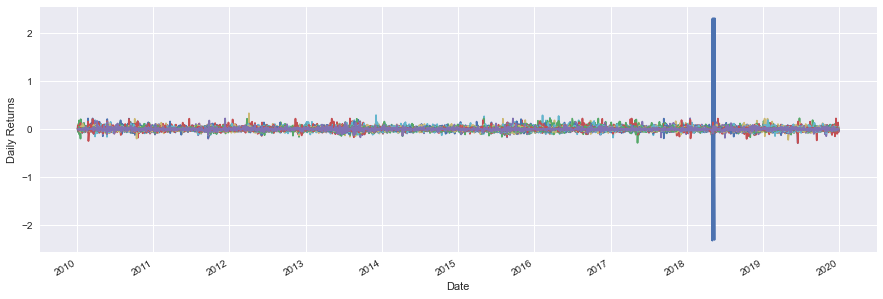

In [46]:
ret_all.plot(legend=False, ylabel='Daily Returns', figsize=(15,5))

In [47]:
ret_all.max().sort_values()

ICBP.JK    0.092659
INDF.JK    0.098671
JSMR.JK    0.103184
ASII.JK    0.106972
BBCA.JK    0.109199
             ...   
INDY.JK    0.226882
PGAS.JK    0.227390
DOID.JK    0.292136
BDMN.JK    0.330242
MAPI.JK    2.308777
Length: 52, dtype: float64

In [48]:
# ret_all.info()

### **Daily Price Movements**

In [49]:
open_price = df1['Open'][:training_year].dropna(how='all')
close_price = df1['Close'][:training_year].dropna(how='all')

In [50]:
daily_movt = log_rate(close_price/open_price).fillna(0)

In [51]:
daily_movt_corr=daily_movt.ewm(span=300).mean().corr()

In [52]:
daily_movt_dist=np.sqrt((1-daily_movt_corr)*2.0)

## **Volume**

In [53]:
stocks_volume = df1['Volume'][:training_year].dropna(how='all', axis=1)
stocks_volume_d_avg=stocks_volume.mean()
stocks_volume_total = stocks_volume.sum()

<AxesSubplot:xlabel='Date'>

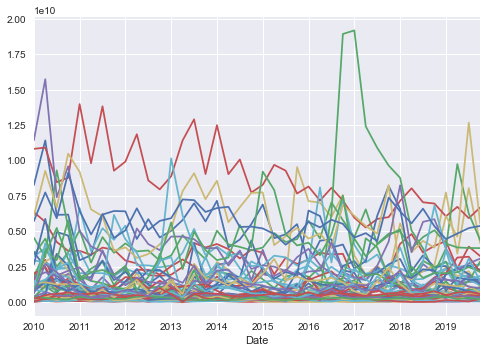

In [54]:
stocks_volume.resample('BQ').sum().plot(legend=False)

In [55]:
market_volume =  df2['Volume'][:training_year]
market_volume_d_avg=market_volume.mean()
market_volume_total = market_volume.sum()

In [56]:
avg_daily_volume_ratio = stocks_volume_d_avg / market_volume_d_avg
avg_daily_volume_ratio.sort_values()

GGRM.JK    0.000289
AALI.JK    0.000365
ITMG.JK    0.000412
ISAT.JK    0.000622
INTP.JK    0.000700
             ...   
BRPT.JK    0.017893
BBCA.JK    0.018370
TLKM.JK    0.024809
LPKR.JK    0.025263
BBRI.JK    0.037656
Length: 52, dtype: float64

In [57]:
total_volume_ratio = stocks_volume_total / market_volume_total
total_volume_ratio.sort_values()

GGRM.JK    0.000290
AALI.JK    0.000367
ITMG.JK    0.000414
ISAT.JK    0.000625
INTP.JK    0.000703
             ...   
BRPT.JK    0.017929
BBCA.JK    0.018452
TLKM.JK    0.024880
LPKR.JK    0.025335
BBRI.JK    0.037779
Length: 52, dtype: float64

In [58]:
volume_data = pd.DataFrame({'Total Vol. Ratio':total_volume_ratio, 
                            'Avg. Trading Vol. Ratio (Daily)':avg_daily_volume_ratio})
volume_data.sort_values(by='Total Vol. Ratio')

,Total Vol. Ratio,Avg. Trading Vol. Ratio (Daily)
GGRM.JK,0.000290,0.000289
AALI.JK,0.000367,0.000365
ITMG.JK,0.000414,0.000412
ISAT.JK,0.000625,0.000622
INTP.JK,0.000703,0.000700
...,...,...
BRPT.JK,0.017929,0.017893
BBCA.JK,0.018452,0.018370
TLKM.JK,0.024880,0.024809
LPKR.JK,0.025335,0.025263


In [59]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], str(point['val']), fontweight='semibold', alpha=0.7)

# data_plot=volume_data

# fig, ax = plt.subplots(figsize = [10,8])
# ax = sns.scatterplot(x='Total Vol. Ratio', y='Avg. Trading Vol. Ratio (Daily)', 
#                 data=data_plot, s=100)
# ax.set_title('Trade Volume of Stocks vs Market Volume', fontsize=20)
# label_point(data_plot['Total Vol. Ratio'], data_plot['Avg. Trading Vol. Ratio (Daily)'],
#             data_plot.index.to_series(), ax)

### **Data Clean Up**

Here we can see that there are definite outliers in the data. To clean up the data, we caculate the _Z-score_ of each stock (column) and remove any value that has a _Z-score_ of above $\pm 3\sigma$.

In [60]:
from scipy import stats

In [61]:
ret = ret_all.apply(lambda col: col[np.abs(stats.zscore(col, nan_policy='omit')) < 3])
ret = ret.interpolate(method='time')

<AxesSubplot:xlabel='Date', ylabel='Daily Returns'>

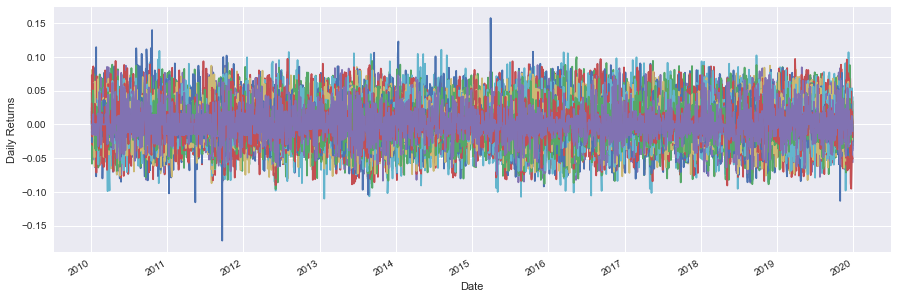

In [62]:
ret.plot(legend=False, ylabel='Daily Returns', figsize=(15,5))

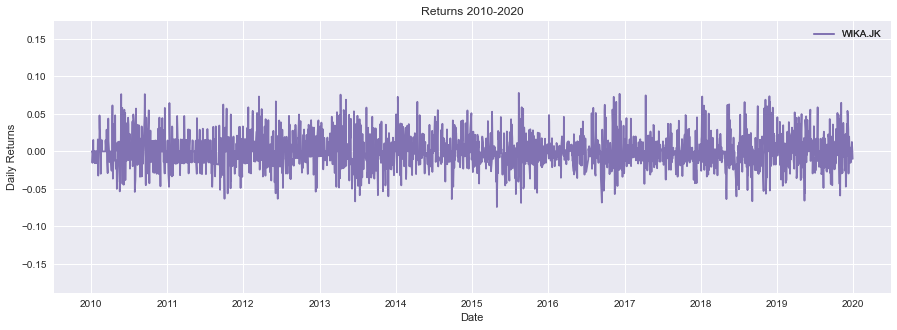

In [63]:
fig = plt.figure(figsize=[15,5])
camera = Camera(fig)
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.title('Returns 2010-2020')

for i in range(len(ret.columns)):
    data = ret.iloc[:, i]
    t=plt.plot(data)
    plt.legend(t,[data.name])
    camera.snap()
    
animation = camera.animate()
animation.save('returns.gif')

In [64]:
ret_ann = ret.resample('Y').sum()
ret_ann.index = ret_ann.index.strftime('%Y')

In [65]:
ret_mon = ret.resample('BM').sum()

In [66]:
sample=ret.sample(n=5, axis=1).columns

<AxesSubplot:xlabel='Date', ylabel='Daily Return Rate'>

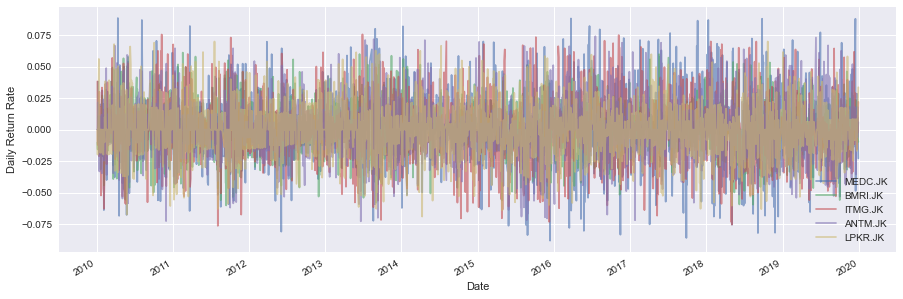

In [67]:
ret[sample].plot(ylabel='Daily Return Rate', alpha=0.6, figsize=(15,5))

In [68]:
ret[sample]

,MEDC.JK,BMRI.JK,ITMG.JK,ANTM.JK,LPKR.JK
Date,,,,,
2010-01-05,0.000000,-0.010204,0.038260,0.000000,0.000000
2010-01-06,0.000000,-0.015504,-0.009050,0.000000,-0.019803
2010-01-07,0.000000,-0.015748,-0.012195,0.021506,0.000000
2010-01-08,0.038100,0.010527,0.001532,0.000000,0.000000
2010-01-11,-0.009390,-0.005250,0.009147,-0.010695,0.039221
...,...,...,...,...,...
2019-12-20,0.000000,0.013072,0.011074,-0.006006,-0.008368
2019-12-23,0.028492,0.003241,-0.015539,-0.006042,-0.016950
2019-12-26,-0.011300,0.009662,0.006689,0.018019,-0.008584


<AxesSubplot:xlabel='Date', ylabel='Monthly Return Rate'>

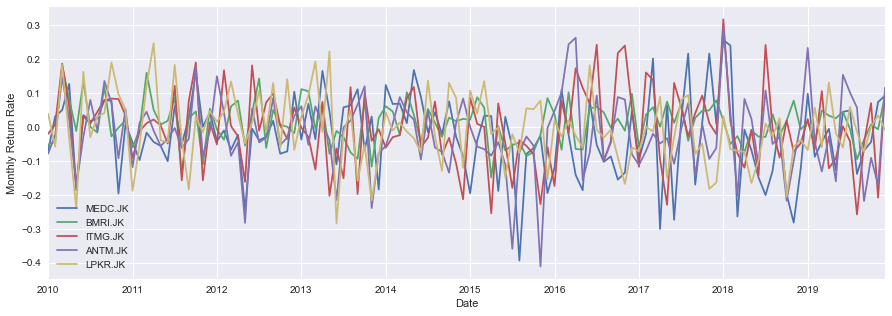

In [69]:
ret_mon[sample].plot(ylabel='Monthly Return Rate', figsize=(15,5))

<AxesSubplot:xlabel='Date', ylabel='Annual Return Rate'>

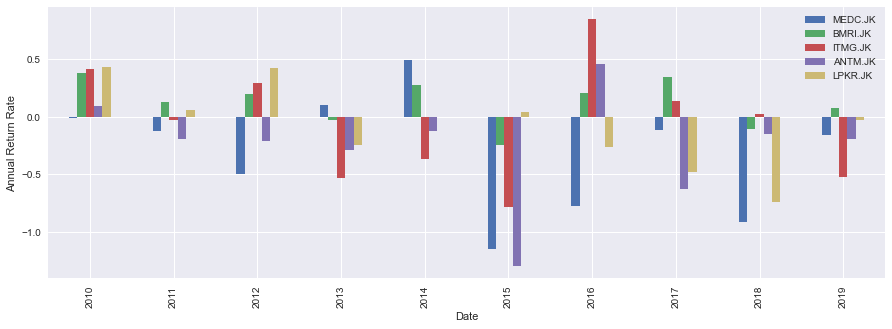

In [70]:
ret_ann[sample].plot(kind='bar', ylabel='Annual Return Rate',figsize=(15,5))

In [71]:
freq = ret.apply(lambda col: col.value_counts())

### **Distributions of Rate of Return**

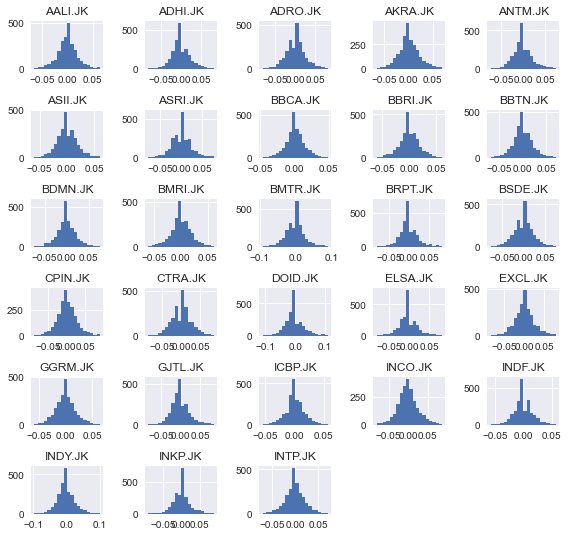

In [72]:
ret.iloc[:,:28].hist(bins=20,figsize=(8,16), layout=(13,5))
plt.tight_layout()

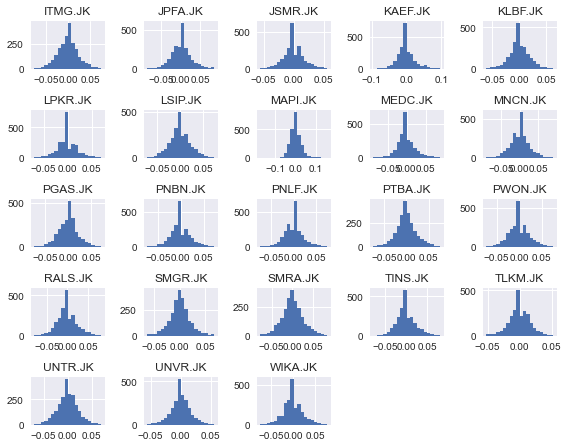

In [73]:
ret.iloc[:,29:].hist(bins=20,figsize=(8,16), layout=(13,5))
plt.tight_layout()

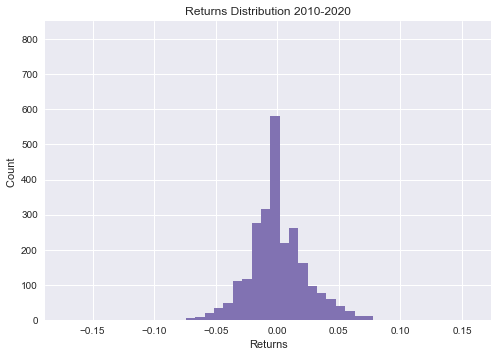

In [74]:
fig = plt.figure()
camera = Camera(fig)
plt.xlabel('Returns')
plt.ylabel('Count ')
plt.title('Returns Distribution 2010-2020')

for i in range(len(ret.columns)):
    data = ret.iloc[:, i]
    s=plt.hist(data, bins=20, label=data.name)
    camera.snap()
    
animation = camera.animate()
animation.save('returns-dist.gif')

# **Correlation Matrix of Stocks**

In [75]:
corr_matrix = ret.corr()#.ewm(span=300).corr()
#corr_matrix = corr_matrix.loc[corr_matrix.index.levels[0][-1]]

In [76]:
# corr_matrix.info()

<AxesSubplot:>

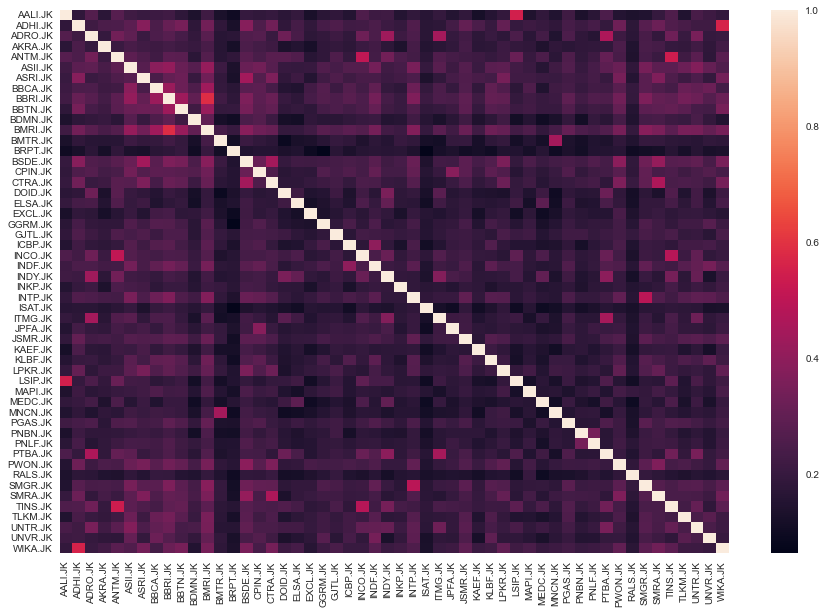

In [77]:
plt.subplots(figsize=(15,10))
sns.heatmap(corr_matrix)

## **Distance Matrix**

This is an _experimental_ variable where each stock is assigned a _score_ based on its average correlation value to other stocks in KOMPAS100. A low score may suggests that the stock is highly uncorrelated to other stocks and may help in building a highly diversified portfolio.

In [323]:
def dist_matrix(df):
    return np.sqrt((1-df.corr())*2)

In [79]:
from sklearn.metrics import pairwise_distances

dist_matrix_sk = pd.DataFrame(pairwise_distances(ret.T), index=ret.columns, columns=ret.columns).round(3)

In [80]:
dist_matrix_sk

,AALI.JK,ADHI.JK,ADRO.JK,AKRA.JK,ANTM.JK,ASII.JK,ASRI.JK,BBCA.JK,BBRI.JK,BBTN.JK,...,PTBA.JK,PWON.JK,RALS.JK,SMGR.JK,SMRA.JK,TINS.JK,TLKM.JK,UNTR.JK,UNVR.JK,WIKA.JK
AALI.JK,0.000,1.380,1.361,1.316,1.229,1.189,1.356,1.079,1.177,1.299,...,1.307,1.393,1.456,1.289,1.460,1.327,1.171,1.266,1.135,1.343
ADHI.JK,1.380,0.000,1.506,1.369,1.367,1.268,1.300,1.208,1.237,1.272,...,1.471,1.350,1.535,1.312,1.437,1.432,1.248,1.404,1.275,1.077
ADRO.JK,1.361,1.506,0.000,1.467,1.335,1.314,1.514,1.266,1.324,1.423,...,1.242,1.504,1.588,1.394,1.616,1.406,1.335,1.325,1.349,1.496
AKRA.JK,1.316,1.369,1.467,0.000,1.337,1.229,1.391,1.143,1.227,1.323,...,1.413,1.362,1.500,1.265,1.471,1.427,1.205,1.330,1.220,1.361
ANTM.JK,1.229,1.367,1.335,1.337,0.000,1.191,1.361,1.141,1.188,1.266,...,1.305,1.368,1.502,1.273,1.494,1.083,1.185,1.280,1.225,1.312
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TINS.JK,1.327,1.432,1.406,1.427,1.083,1.279,1.430,1.231,1.263,1.322,...,1.347,1.447,1.564,1.347,1.526,0.000,1.269,1.330,1.313,1.382
TLKM.JK,1.171,1.248,1.335,1.205,1.185,1.013,1.265,0.890,0.987,1.131,...,1.272,1.233,1.365,1.099,1.346,1.269,0.000,1.172,0.978,1.232
UNTR.JK,1.266,1.404,1.325,1.330,1.280,1.127,1.370,1.095,1.161,1.312,...,1.268,1.392,1.492,1.250,1.468,1.330,1.172,0.000,1.181,1.379
UNVR.JK,1.135,1.275,1.349,1.220,1.225,1.034,1.290,0.898,1.049,1.176,...,1.279,1.280,1.371,1.131,1.377,1.313,0.978,1.181,0.000,1.253


<AxesSubplot:>

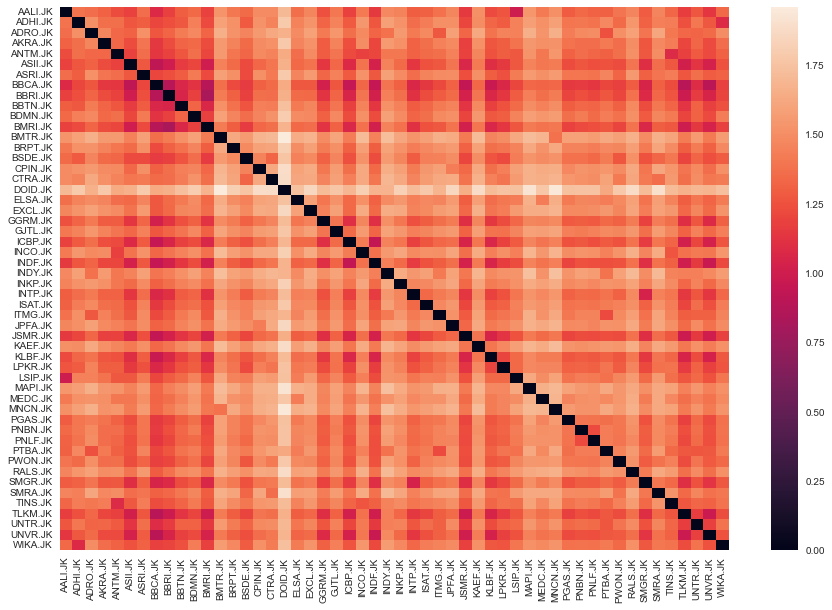

In [81]:
plt.subplots(figsize=(15,10))
sns.heatmap(dist_matrix_sk)

In [82]:
from scipy.spatial.distance import pdist
cond_dist_matrix = pdist(ret)

In [83]:
cond_dist_matrix

array([0.2407549 , 0.22807455, 0.17914825, ..., 0.12982004, 0.16695938,
       0.1727939 ])

## **Market (KOMPAS100 Index) Rate of Return**

In [84]:
market_price = df2[:training_year]['Close']
rate_market = log_rate(market_price).interpolate(method='time')
rate_market

Date
2010-01-05    0.012389
2010-01-06   -0.001602
2010-01-07   -0.006960
2010-01-08    0.010556
2010-01-11    0.006463
                ...   
2019-12-20    0.008202
2019-12-23    0.002771
2019-12-26    0.001667
2019-12-27    0.001338
2019-12-30   -0.007285
Name: Close, Length: 2450, dtype: float64

In [85]:
rate_market_ann=market_price.resample('Y').ffill().pct_change().dropna()

In [86]:
rate_market_annual = rate_market_ann.mean()

In [87]:
rate_market_annual

0.05188717732205609

<AxesSubplot:xlabel='Date', ylabel='Daily Return Rate'>

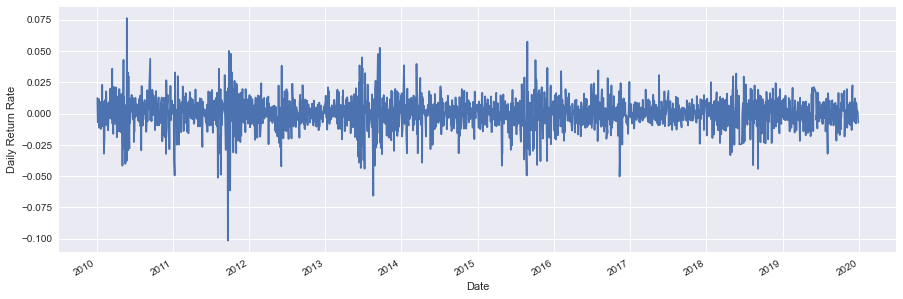

In [88]:
rate_market.plot(legend=False, ylabel='Daily Return Rate', figsize=(15,5))

## **Daily Bond Yield**

In [89]:
rate_bond = bond_yield['Close'][:training_year]
rate_bond.mean()

0.06260185291700894

In [90]:
daily_rf = (rate_bond)*(1/(365))
daily_rf

Date
2010-01-04    0.000207
2010-01-05    0.000174
2010-01-06    0.000185
2010-01-07    0.000170
2010-01-08    0.000181
                ...   
2019-12-20    0.000142
2019-12-23    0.000141
2019-12-26    0.000138
2019-12-27    0.000139
2019-12-30    0.000138
Name: Close, Length: 2434, dtype: float64

<AxesSubplot:xlabel='Date', ylabel='Daily Risk-free Rate'>

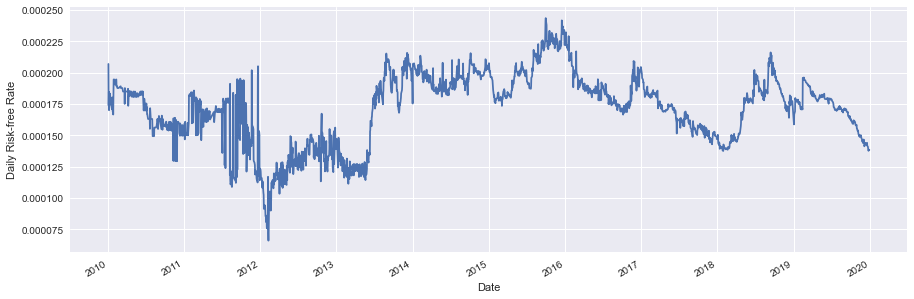

In [91]:
daily_rf.plot(ylabel='Daily Risk-free Rate', figsize=(15,5))

## **Excess Market Returns**

In [92]:
excess_ret_mar = ret.apply(lambda column: column-rate_market[rate_market.index.isin(column.index)]).dropna()

<AxesSubplot:xlabel='Date'>

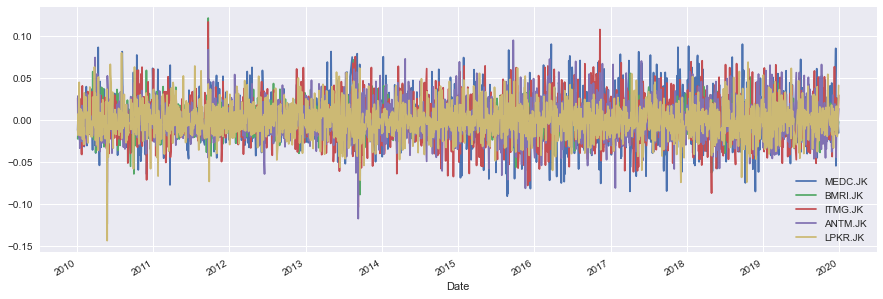

In [93]:
excess_ret_mar[sample].plot(figsize=(15,5))

In [94]:
excess_ret_mar

,AALI.JK,ADHI.JK,ADRO.JK,AKRA.JK,ANTM.JK,ASII.JK,ASRI.JK,BBCA.JK,BBRI.JK,BBTN.JK,...,PTBA.JK,PWON.JK,RALS.JK,SMGR.JK,SMRA.JK,TINS.JK,TLKM.JK,UNTR.JK,UNVR.JK,WIKA.JK
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,0.002180,-0.037081,0.010211,-0.028918,-0.012389,-0.006739,0.006480,-0.002536,-0.005999,-0.012389,...,-0.012389,0.006660,0.060637,0.000683,0.005003,0.010868,-0.007167,0.012770,0.018794,-0.012389
2010-01-06,-0.002539,0.014024,0.007173,-0.006767,0.001602,-0.004048,0.001602,-0.028251,-0.011219,0.001602,...,0.023825,-0.056667,-0.026972,0.014505,0.018696,0.013031,-0.008870,-0.001509,-0.007209,0.001602
2010-01-07,0.045622,0.019230,0.028939,-0.009989,0.028466,-0.024697,0.016262,0.011998,-0.006027,0.006960,...,0.009703,-0.003091,-0.022454,-0.005943,0.006960,-0.004469,-0.019708,-0.005579,-0.010898,0.006960
2010-01-08,-0.002604,0.001565,0.052623,-0.019140,-0.010556,-0.004725,0.016843,-0.036003,-0.004042,0.021192,...,-0.007820,-0.000506,-0.025594,-0.017071,-0.010556,-0.010556,0.000197,0.023556,-0.006062,-0.025824
2010-01-11,-0.018415,-0.018584,0.003689,0.010631,-0.017158,0.009399,0.046181,0.003794,-0.006463,-0.027516,...,-0.017452,-0.006463,-0.037235,0.006524,-0.006463,0.004966,0.004176,0.044068,0.002466,-0.006463
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-20,0.008573,-0.016501,-0.043294,0.006988,-0.014208,0.002687,-0.041263,0.000848,-0.005906,-0.017548,...,-0.027250,-0.016936,-0.047423,-0.024235,-0.023165,-0.020398,0.022103,-0.030309,0.014271,-0.023240
2019-12-23,0.002759,-0.015350,0.022871,-0.007809,-0.008813,-0.006388,-0.002771,-0.002771,0.017661,-0.007477,...,0.001068,-0.011582,0.046019,-0.012924,-0.002771,-0.002771,-0.002771,-0.005127,-0.002171,-0.010376
2019-12-26,0.034438,-0.005895,0.001493,0.000855,0.016352,-0.005297,0.006701,0.001332,-0.010696,0.003039,...,0.009762,0.015877,-0.001667,0.004437,0.003346,0.010528,-0.006654,0.018182,0.017359,0.010976


## **Market Premium**

In [95]:
market_premium = (rate_market[rate_market.index.isin(daily_rf.index)] - daily_rf).dropna()
market_premium.mean()

0.000111834645280038

<AxesSubplot:xlabel='Date'>

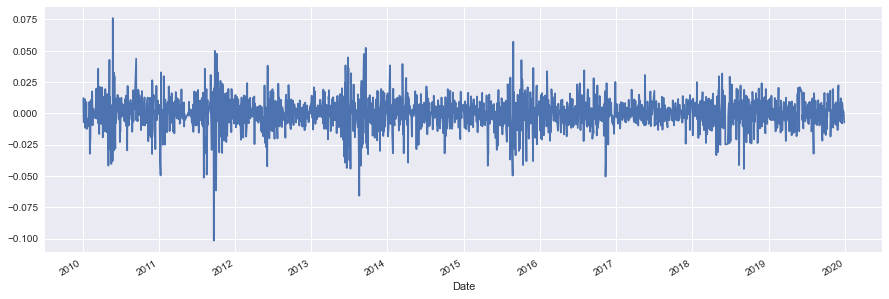

In [96]:
market_premium.plot(figsize=(15,5))

In [97]:
market_premium.sort_values()

Date
2011-09-22   -0.101680
2013-08-19   -0.065799
2011-10-03   -0.061567
2011-08-05   -0.051411
2016-11-11   -0.050456
                ...   
2011-10-06    0.047585
2011-09-27    0.049916
2013-09-19    0.052321
2015-08-27    0.057259
2010-05-26    0.076126
Name: Close, Length: 2433, dtype: float64

## **Risk Premium**

In [98]:
risk_premium = ret.apply(lambda column: column-daily_rf[daily_rf.index.isin(column.index)]).dropna()

<AxesSubplot:xlabel='Date'>

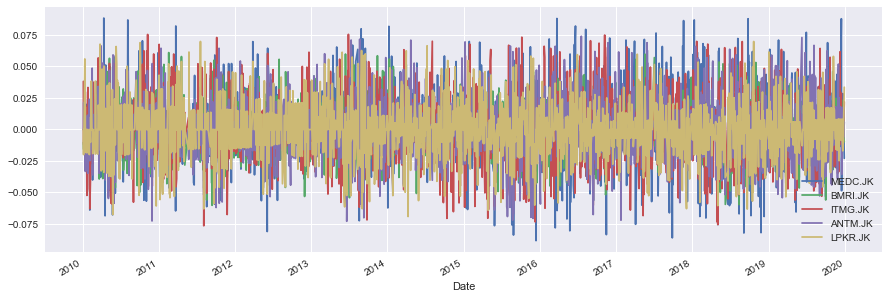

In [99]:
risk_premium[sample].plot(figsize=(15,5))

In [100]:
risk_premium

,AALI.JK,ADHI.JK,ADRO.JK,AKRA.JK,ANTM.JK,ASII.JK,ASRI.JK,BBCA.JK,BBRI.JK,BBTN.JK,...,PTBA.JK,PWON.JK,RALS.JK,SMGR.JK,SMRA.JK,TINS.JK,TLKM.JK,UNTR.JK,UNVR.JK,WIKA.JK
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,0.014395,-0.024867,0.022426,-0.016703,-0.000174,0.005476,0.018695,0.009679,0.006216,-0.000174,...,-0.000174,0.018874,0.072852,0.012898,0.017218,0.023083,0.005048,0.024984,0.031009,-0.000174
2010-01-06,-0.004325,0.012238,0.005387,-0.008553,-0.000185,-0.005834,-0.000185,-0.030038,-0.013005,-0.000185,...,0.022038,-0.058454,-0.028758,0.012719,0.016910,0.011244,-0.010656,-0.003295,-0.008996,-0.000185
2010-01-07,0.038492,0.012100,0.021809,-0.017119,0.021336,-0.031827,0.009132,0.004868,-0.013157,-0.000170,...,0.002573,-0.010220,-0.029584,-0.013073,-0.000170,-0.011599,-0.026838,-0.012709,-0.018027,-0.000170
2010-01-08,0.007771,0.011940,0.062998,-0.008765,-0.000181,0.005650,0.027218,-0.025628,0.006334,0.031568,...,0.002555,0.009869,-0.015219,-0.006696,-0.000181,-0.000181,0.010572,0.033931,0.004313,-0.015449
2010-01-11,-0.012133,-0.012301,0.009972,0.016914,-0.010875,0.015682,0.052464,0.010076,-0.000180,-0.021234,...,-0.011169,-0.000180,-0.030952,0.012807,-0.000180,0.011249,0.010458,0.050351,0.008748,-0.000180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-20,0.016634,-0.008441,-0.035233,0.015049,-0.006148,0.010748,-0.033203,0.008908,0.002155,-0.009487,...,-0.019190,-0.008875,-0.039362,-0.016174,-0.015105,-0.012337,0.030164,-0.022248,0.022331,-0.015180
2019-12-23,0.005389,-0.012720,0.025502,-0.005179,-0.006183,-0.003758,-0.000141,-0.000141,0.020291,-0.004847,...,0.003698,-0.008952,0.048649,-0.010293,-0.000141,-0.000141,-0.000141,-0.002497,0.000459,-0.007746
2019-12-26,0.035968,-0.004366,0.003022,0.002384,0.017881,-0.003768,0.008231,0.002861,-0.009167,0.004568,...,0.011291,0.017407,-0.000138,0.005966,0.004875,0.012058,-0.005125,0.019711,0.018888,0.012505


In [101]:
def reg_plot(x,y):
    exog = x[x.index.isin(y.index)]
    endog = y[y.index.isin(x.index)]
    reg_analysis=pd.DataFrame({'Risk Premium': endog, 'Market Premium':exog})
    fig, ax = plt.subplots()
    sns.regplot(x='Market Premium', y= 'Risk Premium', data= reg_analysis, ci=None,\
            line_kws={'color':'r'},scatter_kws={"s": 20}, ax=ax)
    ax.axhline(y=0, color='k', linewidth=1)  
    ax.axvline(x=0, color='k', linewidth=1)

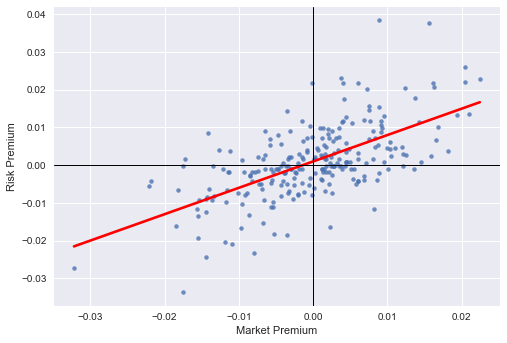

In [102]:
y = risk_premium['BBCA.JK'].loc[training_year]
x = market_premium.loc[training_year]
reg_plot(x,y)

## **Daily Sharpe**

In [103]:
daily_sr = (risk_premium/daily_movt)

In [104]:
daily_sr.replace([np.inf, -np.inf], np.nan, inplace=True)

In [105]:
daily_sr.dropna(inplace=True)

## **Instruments Analysis**

In [106]:
def lin_regression(asset_ret, market_ret):
    stock = asset_ret[asset_ret.index.isin(market_ret.index)] 
    market = market_ret[market_ret.index.isin(stock.index)] 
    reg = stock.apply(lambda col: stats.linregress(col.dropna(), market[market.index.isin(col.dropna().index)]))
    return reg

In [107]:
#Training Data
train_ret = ret[:training_year]
res= pd.DataFrame()
metrics =pd.DataFrame()
sharpe =pd.DataFrame()
risk=pd.DataFrame()

for year in range(2010, int(training_year)):
    
    yr = f'{year}'

    #Covariances
    tr_cov = train_ret[:yr].cov()
    tr_std = train_ret[:yr].std()
    tr_semicov = train_ret[:yr][train_ret[:yr] < 0].cov()
    tr_mar_cov = train_ret[:yr].apply(lambda col: col.cov(rate_market[:yr]))
    tr_mar_var = rate_market[:yr].var()

    #Regression
    tr_y = risk_premium.loc[:yr]
    tr_x = market_premium.loc[:yr]
    reg = lin_regression(tr_y,tr_x)
    tr_alpha = reg.iloc[1]
    tr_beta = reg.iloc[0]
    tr_rsq = reg.iloc[2]
    tr_sse = reg.iloc[4]


    #Expected Returns Market
    tr_market_er = rate_market[:yr].mean()*252
    tr_risk_free = daily_rf[:yr].mean()*365
    tr_er_marketprem = (tr_market_er - tr_risk_free)

    #CAPM Beta 
    tr_beta_stat = tr_mar_cov.divide(tr_mar_var)

    #LReg Expected Return
    tr_beta_prem = tr_beta.apply(lambda x: x*(market_premium.loc[yr])).T
    tr_lreg_ret = tr_alpha + tr_beta_prem.sum() + tr_risk_free
    tr_exp_ret = tr_lreg_ret

    #CAPM Expected Return
    tr_beta_prem_stat = tr_beta_stat*tr_er_marketprem
    tr_ols = (tr_beta_prem_stat + tr_risk_free)
    tr_exp_ret_stat = tr_ols

    #Annualised Return
    tr_mean_ret = train_ret[:yr].mean()
    tr_ind_er = tr_mean_ret*(252)
    
    #Exponentially Weighted 
    tr_300ewm_ret = train_ret[:yr].ewm(span=300).mean().iloc[-1]
    tr_300ewm_er = tr_300ewm_ret*252
    tr_500ewm_ret = train_ret[:yr].ewm(span=500).mean().iloc[-1]
    tr_500ewm_er = tr_500ewm_ret*252
    tr300_sd = train_ret[:yr].ewm(span=300).std().iloc[-1]*np.sqrt(252)
    tr300_semisd= train_ret[:yr][train_ret[:yr]<0].ewm(span=300).std().iloc[-1]*np.sqrt(252)
    tr500_sd = train_ret[:yr].ewm(span=500).std().iloc[-1]*np.sqrt(252)
    tr500_semisd= train_ret[:yr][train_ret[:yr]<0].ewm(span=500).std().iloc[-1]*np.sqrt(252)
    
    #Ex-ante Sharpe
    tr_sharpe_ante = (tr_exp_ret - tr_risk_free)/(tr_std*np.sqrt(252))
    tr_sharpe_ante_capm = (tr_exp_ret_stat - tr_risk_free)/(tr_std*np.sqrt(252))
    tr_sharpe_ante_ann = (tr_ind_er - tr_risk_free)/(tr_std*np.sqrt(252))
    tr_sharpe_ante_300ewm = (tr_300ewm_er - tr_risk_free)/(tr_std*np.sqrt(252))
    tr_sharpe_ante_500ewm = (tr_500ewm_er - tr_risk_free)/(tr_std*np.sqrt(252))
    
    #Real Return 2019
    tr_ret = ret_ann.loc[f'{year+1}']
    tr_real_std = ret.loc[f'{year+1}'].std()
    
    #Ex-post Sharpe
    tr_sharpe_post = (tr_ret - tr_risk_free)/(tr_real_std*np.sqrt(252))    
    
    rets_data = pd.DataFrame({'Exp. Ret. (LinReg)': tr_exp_ret, 'Exp. Ret. (OLS)': tr_exp_ret_stat, 'Exp. Annualised Return': tr_ind_er, 'Exp. 300 EMA Return':tr_300ewm_er,'Exp. 500 EMA Return':tr_500ewm_er,
                              'Realised Return': tr_ret}).T.stack()
    metrics_data = pd.DataFrame({'Beta(CAPM)':tr_beta_stat, 'Beta (LinReg)': tr_beta, 'Alpha (LinReg)':tr_alpha}).T.stack()
    sharpe_data = pd.DataFrame({'Ex-Ante Sharpe LinReg':tr_sharpe_ante, 'Ex-Ante Sharpe CAPM':tr_sharpe_ante_capm, 'Ex-Ante Sharpe AnnRet':tr_sharpe_ante_ann, 
                                'Ex-Ante Sharpe 300 EMA':tr_sharpe_ante_300ewm, 'Ex-Ante Sharpe 500 EMA':tr_sharpe_ante_500ewm,'Ex-Post Sharpe':tr_sharpe_post}).T.stack()
    risk_data = pd.DataFrame({'Expected Volatility': tr_std*np.sqrt(252), 'EMA-300 Volatility': tr300_sd,'EMA-500 Volatility': tr500_sd, 'Realised Volatility':tr_real_std*np.sqrt(252)}).T.stack()
    
    res[f'{year+1}'] = rets_data
    metrics[f'{year+1}'] = metrics_data
    sharpe[f'{year+1}'] = sharpe_data
    risk[f'{year+1}'] = risk_data


In [108]:
res_mean_ann=res.groupby(axis=0, level=0).mean().T

<AxesSubplot:title={'center':'Annual Average of Returns'}>

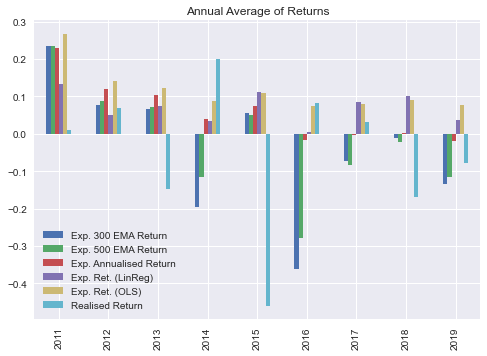

In [109]:
res_mean_ann.plot(kind='bar', title='Annual Average of Returns')

In [110]:
ttest_rets = res_mean_ann.apply(lambda col: stats.ttest_ind(col, res_mean_ann['Realised Return']))
ttest_rets.rename(index={0:'t-statistics', 1:'p-value'},inplace=True)

In [111]:
ttest_rets

,Exp. 300 EMA Return,Exp. 500 EMA Return,Exp. Annualised Return,Exp. Ret. (LinReg),Exp. Ret. (OLS),Realised Return
t-statistics,0.150629,0.397538,1.568814,1.838685,2.492146,0.0
p-value,0.882151,0.696224,0.136254,0.084597,0.024051,1.0


In [112]:
res_mean_ann.corr()

,Exp. 300 EMA Return,Exp. 500 EMA Return,Exp. Annualised Return,Exp. Ret. (LinReg),Exp. Ret. (OLS),Realised Return
Exp. 300 EMA Return,1.000000,0.987571,0.821627,0.845775,0.777592,-0.381211
Exp. 500 EMA Return,0.987571,1.000000,0.894251,0.797924,0.837113,-0.301228
Exp. Annualised Return,0.821627,0.894251,1.000000,0.584950,0.947821,-0.028999
Exp. Ret. (LinReg),0.845775,0.797924,0.584950,1.000000,0.623586,-0.545020
Exp. Ret. (OLS),0.777592,0.837113,0.947821,0.623586,1.000000,0.027938
Realised Return,-0.381211,-0.301228,-0.028999,-0.545020,0.027938,1.000000


In [113]:
res_mean_ann.apply(lambda col: (np.square(res_mean_ann['Realised Return']-col)).mean())

Exp. 300 EMA Return       0.083584
Exp. 500 EMA Return       0.069337
Exp. Annualised Return    0.051851
Exp. Ret. (LinReg)        0.057000
Exp. Ret. (OLS)           0.063867
Realised Return           0.000000
dtype: float64

In [114]:
metrics

2011      2012      2013      2014      2015  \
Beta(CAPM)     AALI.JK  0.762264  0.669005  0.713368  0.629167  0.629450   
               ADHI.JK  0.848876  0.797189  0.839446  0.854775  0.927532   
               ADRO.JK  0.867984  0.922377  0.989000  0.921202  0.932917   
               AKRA.JK  0.854440  0.782662  0.848484  0.784034  0.773656   
               ANTM.JK  1.004409  0.867832  0.881997  0.816823  0.786820   
...                          ...       ...       ...       ...       ...   
Alpha (LinReg) TINS.JK  0.001069  0.000559  0.000426  0.000222  0.000320   
               TLKM.JK  0.001423  0.000709  0.000455  0.000223  0.000224   
               UNTR.JK  0.000718  0.000105  0.000380  0.000090  0.000261   
               UNVR.JK  0.000836  0.000135  0.000154  0.000040  0.000119   
               WIKA.JK  0.000387  0.000161 -0.000028 -0.000070 -0.000083   

                            2016      2017      2018      2019  
Beta(CAPM)     AALI.JK  0.652563  0.629077  0.622444  0.596862  
               ADHI.JK  0.912821  0.897207  0.890931  0.879863  
               ADRO.JK  0.915396  0.909118  0.920456  0.921924  
               AKRA.JK  0.697031  0.697413  0.704059  0.709080  
               ANTM.JK  0.768136  0.754818  0.744872  0.766450  
...                          ...       ...       ...       ...  
Alpha (LinReg) TINS.JK  0.000314  0.000236  0.000349  0.000276  
               TLKM.JK  0.000053  0.000045  0.000129  0.000098  
               UNTR.JK  0.000092  0.000120  0.000123  0.000088  
               UNVR.JK -0.000011 -0.000006  0.000005 -0.000018  
               WIKA.JK -0.000103 -0.000012  0.000130  0.000059  

[156 rows x 9 columns]

<AxesSubplot:>

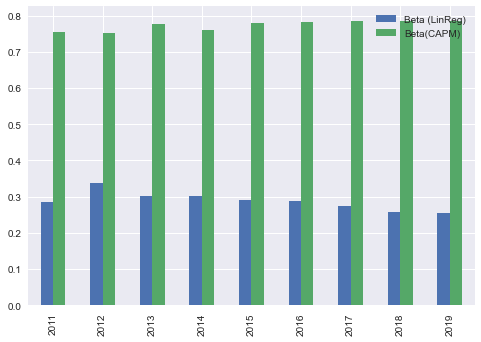

In [115]:
annual_betas = metrics.groupby(level=0).mean().drop('Alpha (LinReg)')
annual_betas.T.plot(kind='bar')

In [116]:
sharpe

2011      2012      2013      2014  \
Ex-Ante Sharpe LinReg AALI.JK  0.266629 -0.032314  0.063055 -0.076436   
                      ADHI.JK  0.145850 -0.018978  0.037082 -0.046800   
                      ADRO.JK  0.248100 -0.024420  0.056155 -0.065995   
                      AKRA.JK  0.193858 -0.026635  0.052734 -0.069815   
                      ANTM.JK  0.271133 -0.036430  0.080957 -0.087853   
...                                 ...       ...       ...       ...   
Ex-Post Sharpe        TINS.JK -0.476029  0.013805  0.046679  0.048148   
                      TLKM.JK -0.496375  0.472110  0.266452  1.397363   
                      UNTR.JK  0.329041 -1.038409  0.756506 -0.388564   
                      UNVR.JK  0.829238  0.242616 -0.318101  0.817672   
                      WIKA.JK -0.693263  1.842115 -0.334740  2.520315   

                                   2015      2016      2017      2018  \
Ex-Ante Sharpe LinReg AALI.JK  0.164075 -0.162751  0.059024  0.112707   
                      ADHI.JK  0.109524 -0.120972  0.048477  0.088817   
                      ADRO.JK  0.134080 -0.135833  0.046072  0.084152   
                      AKRA.JK  0.154288 -0.155945  0.055609  0.100162   
                      ANTM.JK  0.191109 -0.190948  0.069803  0.120865   
...                                 ...       ...       ...       ...   
Ex-Post Sharpe        TINS.JK -2.378450  0.814016 -1.915709 -0.424390   
                      TLKM.JK -0.179853  0.554668 -0.491843 -0.708107   
                      UNTR.JK -0.122402 -0.083338  1.043249 -0.649229   
                      UNVR.JK -0.361178  0.588835  1.873399 -0.742561   
                      WIKA.JK -1.806500 -0.680937 -1.725066  0.175449   

                                   2019  
Ex-Ante Sharpe LinReg AALI.JK -0.077745  
                      ADHI.JK -0.066106  
                      ADRO.JK -0.060178  
                      AKRA.JK -0.074276  
                      ANTM.JK -0.084700  
...                                 ...  
Ex-Post Sharpe        TINS.JK -1.827072  
                      TLKM.JK  0.035647  
                      UNTR.JK -1.320253  
                      UNVR.JK -0.500652  
                      WIKA.JK  0.534987  

[312 rows x 9 columns]

In [117]:
sharpe_mean_ann=sharpe.groupby(axis=0, level=0).mean().T

In [118]:
ttest_sharpe = sharpe_mean_ann.apply(lambda col: stats.ttest_ind(col, sharpe_mean_ann['Ex-Post Sharpe']))
ttest_sharpe.rename(index={0:'t-statistics', 1:'p-value'},inplace=True)

In [119]:
ttest_sharpe

,Ex-Ante Sharpe 300 EMA,Ex-Ante Sharpe 500 EMA,Ex-Ante Sharpe AnnRet,Ex-Ante Sharpe CAPM,Ex-Ante Sharpe LinReg,Ex-Post Sharpe
t-statistics,0.092782,0.337373,1.548335,2.439514,1.746910,0.0
p-value,0.927229,0.740221,0.141093,0.026728,0.099817,1.0


In [120]:
risk_mean_ann = risk.groupby(level=0).mean().T

<AxesSubplot:title={'center':'Annual Average of Volatilities'}>

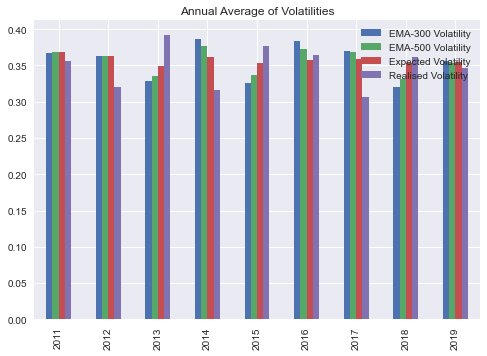

In [121]:
risk_mean_ann.plot(kind='bar', title='Annual Average of Volatilities')

In [122]:
ttest_risk = risk_mean_ann.apply(lambda col: stats.ttest_ind(col, risk_mean_ann['Realised Volatility']))
ttest_risk.rename(index={0:'t-statistics', 1:'p-value'},inplace=True)

In [123]:
ttest_risk

,EMA-300 Volatility,EMA-500 Volatility,Expected Volatility,Realised Volatility
t-statistics,0.503089,0.624508,0.893844,0.0
p-value,0.621757,0.541098,0.384653,1.0


## **Instruments Calculations**

In [124]:
cov = ret.cov()

In [125]:
semicov = ret[ret < 0].cov()

In [126]:
mar_cov = ret.apply(lambda col: col.cov(rate_market[rate_market.index.isin(col.index)]))
mar_cov

AALI.JK    0.000087
ADHI.JK    0.000133
ADRO.JK    0.000137
AKRA.JK    0.000102
ANTM.JK    0.000117
             ...   
TINS.JK    0.000129
TLKM.JK    0.000103
UNTR.JK    0.000135
UNVR.JK    0.000104
WIKA.JK    0.000124
Length: 52, dtype: float64

In [127]:
mar_var = rate_market.var()
mar_var

0.00014734133787240835

In [128]:
y = risk_premium
x = market_premium
reg = lin_regression(y,x)

In [129]:
alpha = reg.iloc[1]
beta = reg.iloc[0]
rsq = reg.iloc[2]
sse = reg.iloc[4]

In [130]:
beta.sort_values()

DOID.JK    0.122330
BRPT.JK    0.140734
MEDC.JK    0.148307
RALS.JK    0.152000
BMTR.JK    0.157946
             ...   
TLKM.JK    0.388652
ASII.JK    0.400088
BBRI.JK    0.425206
BMRI.JK    0.428710
BBCA.JK    0.507507
Name: 0, Length: 52, dtype: float64

In [131]:
alpha.sort_values()

BBCA.JK   -0.000184
BBRI.JK   -0.000147
CPIN.JK   -0.000125
KLBF.JK   -0.000092
MAPI.JK   -0.000079
             ...   
GJTL.JK    0.000328
ELSA.JK    0.000352
INDY.JK    0.000383
ANTM.JK    0.000412
DOID.JK    0.000459
Name: 1, Length: 52, dtype: float64

In [132]:
rsq.sort_values()

BRPT.JK    0.261051
MEDC.JK    0.301208
ISAT.JK    0.305634
RALS.JK    0.309053
ELSA.JK    0.315736
             ...   
TLKM.JK    0.521130
BBCA.JK    0.598001
ASII.JK    0.615128
BBRI.JK    0.641504
BMRI.JK    0.658288
Name: 2, Length: 52, dtype: float64

In [133]:
sse

AALI.JK    0.011646
ADHI.JK    0.009268
ADRO.JK    0.008785
AKRA.JK    0.010575
ANTM.JK    0.010280
             ...   
TINS.JK    0.009254
TLKM.JK    0.012944
UNTR.JK    0.009789
UNVR.JK    0.012686
WIKA.JK    0.009692
Name: 4, Length: 52, dtype: float64

In [134]:
market_er = rate_market.mean()*252
risk_free = daily_rf.mean()*252
er_marketprem = (market_er - risk_free)

In [135]:
er_marketprem

0.030578077448314867

In [136]:
beta_stat = mar_cov.divide(mar_var)
beta_stat

AALI.JK    0.591624
ADHI.JK    0.901060
ADRO.JK    0.932086
AKRA.JK    0.694903
ANTM.JK    0.793994
             ...   
TINS.JK    0.877070
TLKM.JK    0.700478
UNTR.JK    0.914988
UNVR.JK    0.707158
WIKA.JK    0.843771
Length: 52, dtype: float64

In [137]:
beta_prem = beta.apply(lambda row: row*market_premium[training_year]).T

In [138]:
beta_prem

,AALI.JK,ADHI.JK,ADRO.JK,AKRA.JK,ANTM.JK,ASII.JK,ASRI.JK,BBCA.JK,BBRI.JK,BBTN.JK,...,PTBA.JK,PWON.JK,RALS.JK,SMGR.JK,SMRA.JK,TINS.JK,TLKM.JK,UNTR.JK,UNVR.JK,WIKA.JK
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,-0.000043,-0.000045,-0.000042,-0.000042,-0.000049,-0.000077,-0.000045,-0.000098,-0.000082,-0.000056,...,-0.000043,-0.000049,-0.000029,-0.000059,-0.000041,-0.000043,-0.000075,-0.000055,-0.000072,-0.000046
2019-01-03,0.001824,0.001937,0.001770,0.001811,0.002070,0.003277,0.001905,0.004157,0.003483,0.002380,...,0.001829,0.002070,0.001245,0.002518,0.001746,0.001838,0.003184,0.002335,0.003060,0.001965
2019-01-04,0.002453,0.002606,0.002380,0.002436,0.002785,0.004408,0.002562,0.005592,0.004685,0.003202,...,0.002460,0.002785,0.001675,0.003387,0.002348,0.002473,0.004282,0.003140,0.004116,0.002643
2019-01-07,0.000761,0.000808,0.000738,0.000756,0.000864,0.001368,0.000795,0.001735,0.001453,0.000993,...,0.000763,0.000864,0.000520,0.001051,0.000729,0.000767,0.001328,0.000974,0.001277,0.000820
2019-01-08,-0.001064,-0.001130,-0.001032,-0.001056,-0.001207,-0.001911,-0.001111,-0.002425,-0.002031,-0.001388,...,-0.001067,-0.001207,-0.000726,-0.001469,-0.001018,-0.001072,-0.001857,-0.001362,-0.001785,-0.001146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-20,0.001795,0.001906,0.001741,0.001782,0.002037,0.003225,0.001874,0.004091,0.003427,0.002342,...,0.001800,0.002037,0.001225,0.002478,0.001718,0.001809,0.003133,0.002297,0.003011,0.001933
2019-12-23,0.000586,0.000622,0.000568,0.000582,0.000665,0.001052,0.000612,0.001335,0.001118,0.000764,...,0.000587,0.000665,0.000400,0.000809,0.000561,0.000590,0.001022,0.000750,0.000982,0.000631
2019-12-26,0.000340,0.000362,0.000330,0.000338,0.000386,0.000612,0.000356,0.000776,0.000650,0.000444,...,0.000341,0.000386,0.000232,0.000470,0.000326,0.000343,0.000594,0.000436,0.000571,0.000367


In [139]:
beta_prem_stat = (beta_stat*er_marketprem)

In [140]:
beta_prem_stat.sort_values()

BRPT.JK    0.015004
ISAT.JK    0.016484
AALI.JK    0.018091
ELSA.JK    0.018900
MEDC.JK    0.018922
             ...   
BSDE.JK    0.030280
SMRA.JK    0.030428
BMRI.JK    0.031092
CTRA.JK    0.031129
CPIN.JK    0.033921
Length: 52, dtype: float64

In [141]:
lreg_ret = alpha + beta_prem.apply(lambda col: col + daily_rf)

In [142]:
exp_ret = lreg_ret.sum()

In [143]:
exp_ret = lreg_ret.sum()

In [144]:
exp_ret.sort_values()

BBCA.JK   -0.016759
BBRI.JK   -0.005467
CPIN.JK    0.005184
KLBF.JK    0.010913
INDF.JK    0.017219
             ...   
MEDC.JK    0.118153
ELSA.JK    0.123749
INDY.JK    0.131055
ANTM.JK    0.136095
DOID.JK    0.151021
Length: 52, dtype: float64

In [145]:
ols = (beta_prem_stat + risk_free)

In [146]:
exp_ret_stat = ols
exp_ret_stat.sort_values()

BRPT.JK    0.058225
ISAT.JK    0.059705
AALI.JK    0.061312
ELSA.JK    0.062121
MEDC.JK    0.062143
             ...   
BSDE.JK    0.073501
SMRA.JK    0.073649
BMRI.JK    0.074313
CTRA.JK    0.074350
CPIN.JK    0.077142
Length: 52, dtype: float64

In [147]:
ret.resample('Y').sum().iloc[-1]

AALI.JK    0.297488
ADHI.JK   -0.273038
ADRO.JK    0.172363
AKRA.JK   -0.092504
ANTM.JK   -0.190808
             ...   
TINS.JK   -0.730165
TLKM.JK    0.070687
UNTR.JK   -0.352360
UNVR.JK   -0.049780
WIKA.JK    0.265568
Name: 2019-12-31 00:00:00, Length: 52, dtype: float64

In [148]:
real_ret = ret_ann.iloc[-1]
real_ret.sort_values()

KAEF.JK   -1.168226
INKP.JK   -1.043406
DOID.JK   -0.810615
TINS.JK   -0.730165
INDY.JK   -0.609629
             ...   
AALI.JK    0.297488
PGAS.JK    0.341031
EXCL.JK    0.362568
BRPT.JK    0.803392
MNCN.JK    0.891767
Name: 2019, Length: 52, dtype: float64

In [149]:
ewm300 = ret.ewm(span=300).mean()

In [150]:
ewm300_er = ewm300.iloc[-1]*252

In [151]:
mean_ret = ret.mean()

In [152]:
ind_er = mean_ret*252
ind_er.sort_values()

DOID.JK   -0.677764
INDY.JK   -0.353874
ELSA.JK   -0.340159
MEDC.JK   -0.321109
ANTM.JK   -0.259027
             ...   
BBRI.JK    0.188171
AKRA.JK    0.195625
KLBF.JK    0.207216
CPIN.JK    0.293456
MAPI.JK    0.295813
Length: 52, dtype: float64

In [153]:
returns = pd.DataFrame({'Exp. Ret. (LinReg)': exp_ret, 'Exp. Ret. (OLS)': exp_ret_stat, 'Annualised Return': ind_er, 'EMA-300 Return': ewm300_er, 'Realised Return':real_ret})

In [154]:
returns.mean()#.plot(kind='bar')

Exp. Ret. (LinReg)    0.070165
Exp. Ret. (OLS)       0.067534
Annualised Return    -0.024271
EMA-300 Return       -0.125330
Realised Return      -0.078518
dtype: float64

In [155]:
returns.sample(n=10)

,Exp. Ret. (LinReg),Exp. Ret. (OLS),Annualised Return,EMA-300 Return,Realised Return
AALI.JK,0.103612,0.061312,-0.145728,0.442900,0.297488
ISAT.JK,0.102308,0.059705,-0.178202,-0.643641,-0.347105
INDF.JK,0.017219,0.066155,0.155371,0.165571,0.099832
CPIN.JK,0.005184,0.077142,0.293456,0.295074,-0.063305
CTRA.JK,0.071611,0.074350,0.013180,-0.078479,-0.083748
GJTL.JK,0.116875,0.067840,-0.200104,-0.271563,-0.246812
MNCN.JK,0.074810,0.067279,-0.032013,0.556540,0.891767
ELSA.JK,0.123749,0.062121,-0.340159,-0.210403,-0.093701
INKP.JK,0.079208,0.066799,-0.049119,-0.527659,-1.043406
LPKR.JK,0.090622,0.065546,-0.081775,-0.172320,-0.025763


In [156]:
returns.corr()

,Exp. Ret. (LinReg),Exp. Ret. (OLS),Annualised Return,EMA-300 Return,Realised Return
Exp. Ret. (LinReg),1.000000,-0.212544,-0.934102,-0.465557,-0.404728
Exp. Ret. (OLS),-0.212544,1.000000,0.240789,-0.007505,-0.091421
Annualised Return,-0.934102,0.240789,1.000000,0.492361,0.437845
EMA-300 Return,-0.465557,-0.007505,0.492361,1.000000,0.889586
Realised Return,-0.404728,-0.091421,0.437845,0.889586,1.000000


In [157]:
returns.cov()

,Exp. Ret. (LinReg),Exp. Ret. (OLS),Annualised Return,EMA-300 Return,Realised Return
Exp. Ret. (LinReg),0.001385,-0.000033,-0.006171,-0.006710,-0.005687
Exp. Ret. (OLS),-0.000033,0.000017,0.000178,-0.000012,-0.000144
Annualised Return,-0.006171,0.000178,0.031524,0.033857,0.029353
EMA-300 Return,-0.006710,-0.000012,0.033857,0.150004,0.130094
Realised Return,-0.005687,-0.000144,0.029353,0.130094,0.142573


In [158]:
ttest_rets = returns.apply(lambda col: stats.ttest_ind(col, real_ret))

In [159]:
ttest_rets.rename(index={0:'t-statistics', 1:'p-value'},inplace=True)

In [160]:
ttest_rets

,Exp. Ret. (LinReg),Exp. Ret. (OLS),Annualised Return,EMA-300 Return,Realised Return
t-statistics,2.825816,2.789107,0.937510,-0.624080,0.0
p-value,0.005675,0.006307,0.350711,0.533968,1.0


In [161]:
returns.apply(lambda col: (np.square(returns['Realised Return']-col)).mean())

Exp. Ret. (LinReg)    0.174450
Exp. Ret. (OLS)       0.161461
Annualised Return     0.116113
EMA-300 Return        0.033957
Realised Return       0.000000
dtype: float64

In [162]:
ann_mon_er = ret_mon.apply(lambda col: col.mean()*12)
ann_mon_er.sort_values()

DOID.JK   -0.664317
INDY.JK   -0.346852
ELSA.JK   -0.333410
MEDC.JK   -0.314738
ANTM.JK   -0.253888
             ...   
BBRI.JK    0.184437
AKRA.JK    0.191744
KLBF.JK    0.203105
CPIN.JK    0.287633
MAPI.JK    0.289944
Length: 52, dtype: float64

In [163]:
ret_ann.tail(3).mean().sort_values()

KAEF.JK   -0.659110
ISAT.JK   -0.577040
TINS.JK   -0.459109
LPKR.JK   -0.413950
MEDC.JK   -0.397675
             ...   
BBRI.JK    0.256810
BBCA.JK    0.281451
CPIN.JK    0.294117
INKP.JK    0.440718
BRPT.JK    0.572277
Length: 52, dtype: float64

### **Ex-Ante Statistics**

In [164]:
exp_sd = ret.ewm(span=300).std().iloc[-1]*np.sqrt(252)
exp_semisd= ret[ret<0].ewm(span=300).std().iloc[-1]*np.sqrt(252)

In [165]:
exp_sd

AALI.JK    0.285881
ADHI.JK    0.315725
ADRO.JK    0.409746
AKRA.JK    0.313855
ANTM.JK    0.371948
             ...   
TINS.JK    0.402781
TLKM.JK    0.238196
UNTR.JK    0.322260
UNVR.JK    0.226025
WIKA.JK    0.386134
Name: 2019-12-30 00:00:00, Length: 52, dtype: float64

In [166]:
exp_excess_ret = ewm300_er - risk_free
exp_sharpe = exp_excess_ret / exp_sd
exp_sortino = exp_excess_ret / exp_semisd

In [167]:
exp_sharpe.sort_values()

KAEF.JK   -3.941737
TINS.JK   -1.840906
DOID.JK   -1.824082
INDY.JK   -1.579290
ISAT.JK   -1.576198
             ...   
PGAS.JK    1.011321
MNCN.JK    1.210979
AALI.JK    1.398062
BBCA.JK    1.424703
BRPT.JK    1.823872
Name: 2019-12-30 00:00:00, Length: 52, dtype: float64

### **Ex-Post Statistics**

In [168]:
ann_sd = ret.std()*np.sqrt(252)
ann_sd.sort_values()

BBCA.JK    0.226730
TLKM.JK    0.257104
UNVR.JK    0.263238
JSMR.JK    0.263462
ICBP.JK    0.269484
             ...   
CPIN.JK    0.420825
MAPI.JK    0.424648
CTRA.JK    0.425832
INDY.JK    0.428165
DOID.JK    0.502836
Length: 52, dtype: float64

In [169]:
ann_semisd = ret[ret<0].std()*np.sqrt(252)
ann_semisd.sort_values()

BBCA.JK    0.155702
JSMR.JK    0.160652
TLKM.JK    0.169750
UNVR.JK    0.172561
INDF.JK    0.173963
             ...   
BMTR.JK    0.262326
INDY.JK    0.262932
CPIN.JK    0.264160
INKP.JK    0.265601
DOID.JK    0.310568
Length: 52, dtype: float64

In [170]:
_expret = ind_er
excess_ret_rf = _expret - risk_free
ann_sharpe = excess_ret_rf.div(ann_sd)
ann_sharpe.sort_values()

DOID.JK   -1.433838
ELSA.JK   -1.027696
MEDC.JK   -0.935813
INDY.JK   -0.927435
ANTM.JK   -0.892002
             ...   
BBRI.JK    0.500083
KLBF.JK    0.567485
CPIN.JK    0.594628
MAPI.JK    0.594828
BBCA.JK    0.619184
Length: 52, dtype: float64

In [171]:
ann_sortino = excess_ret_rf.divide(ann_semisd)
ann_sortino

AALI.JK   -0.897449
ADHI.JK   -0.215970
ADRO.JK   -0.160733
AKRA.JK    0.751940
ANTM.JK   -1.475768
             ...   
TINS.JK   -0.970264
TLKM.JK    0.121659
UNTR.JK   -0.044599
UNVR.JK    0.453952
WIKA.JK    0.390510
Length: 52, dtype: float64

In [172]:
exp_exretmar = _expret - (market_er)
ann_infratio = exp_exretmar.div(ann_sd)
ann_infratio.sort_values()

DOID.JK   -1.494649
ELSA.JK   -1.109664
MEDC.JK   -1.014355
INDY.JK   -0.998851
ANTM.JK   -0.982244
             ...   
BBRI.JK    0.394587
KLBF.JK    0.461673
BBCA.JK    0.484319
CPIN.JK    0.521966
MAPI.JK    0.522819
Length: 52, dtype: float64

In [173]:
ann_riskprem = risk_premium.mean()*252

In [174]:
ret_skew = ret.skew(axis=0)

In [175]:
ret_kurt = ret.kurtosis(axis=0)

In [176]:
ret_kurt

AALI.JK    1.024341
ADHI.JK    1.067771
ADRO.JK    0.700447
AKRA.JK    0.595228
ANTM.JK    1.075841
             ...   
TINS.JK    0.928502
TLKM.JK    0.697553
UNTR.JK    0.450074
UNVR.JK    0.946078
WIKA.JK    0.760921
Length: 52, dtype: float64

In [177]:
assets = pd.concat([exp_ret, exp_ret_stat, ind_er, ewm300_er, ret_mon[-3:-1].sum(), ret_mon[-6:-1].sum(), ret_ann[-2:-1].sum(), ann_sd,
                    ann_semisd, ann_sharpe, exp_sharpe, ann_sortino, exp_sortino, ann_infratio, ret_skew, ret_kurt, alpha, beta, beta_stat, rsq, mcap, 
                    total_volume_ratio, real_ret], axis=1) # Creating a table for visualising returns and volatility of assets

assets.columns = ['Expected Return (LinReg)', 'Expected Return (CAPM)',  'Annualised Return', 'EMA-300 Return', 'Last 3 Months Change', 'Last 6 Months Change', 
                  'Last 2 Year Change','Annualised Volatility', 'Annualised Downside Risk', 'Sharpe', 'Expected Sharpe', 'Sortino', 'Expected Sortino', 'Info. Ratio', 'Skew', 'Kurtosis', 'Alpha', 'Beta', 'Beta (CAPM)','R2',
                  'Market Cap', 'Volume-to-Market Ratio','Realised Return']
assets=assets.join([volume_data, growth_data])
assets

,Expected Return (LinReg),Expected Return (CAPM),Annualised Return,EMA-300 Return,Last 3 Months Change,Last 6 Months Change,Last 2 Year Change,Annualised Volatility,Annualised Downside Risk,Sharpe,...,Beta,Beta (CAPM),R2,Market Cap,Volume-to-Market Ratio,Realised Return,Total Vol. Ratio,Avg. Trading Vol. Ratio (Daily),Mean Rev. Growth,Mean Net Inc. Growth
AALI.JK,0.103612,0.061312,-0.145728,0.442900,0.224662,0.260085,-0.304223,0.311554,0.210540,-0.606471,...,0.222644,0.591624,0.362372,1.636000e+13,0.000367,0.297488,0.000367,0.000365,0.008642,-0.561149
ADHI.JK,0.071826,0.070774,-0.005194,-0.327584,-0.216611,-0.449445,-0.243048,0.373173,0.224174,-0.129739,...,0.236501,0.901060,0.460619,2.920000e+12,0.004496,-0.273038,0.004496,0.004476,0.005370,0.140143
ADRO.JK,0.072057,0.071722,0.003357,0.264974,-0.047628,-0.100471,0.000839,0.396814,0.248012,-0.100459,...,0.216012,0.932086,0.447246,4.318000e+13,0.014482,0.172363,0.014482,0.014441,0.033001,-0.084041
AKRA.JK,0.028059,0.064470,0.195625,-0.189718,-0.111226,-0.169225,-0.391959,0.338924,0.202682,0.449671,...,0.221116,0.694903,0.391324,1.476000e+13,0.002645,-0.092504,0.002645,0.002636,0.104631,-0.097586
ANTM.JK,0.136095,0.067500,-0.259027,-0.354422,-0.262364,-0.322809,-0.151434,0.338843,0.204808,-0.892002,...,0.252717,0.793994,0.447173,6.224000e+13,0.012936,-0.190808,0.012936,0.012894,0.645981,5.051626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TINS.JK,0.109459,0.070040,-0.166994,-0.698260,-0.242115,-0.710806,-0.087946,0.377597,0.216658,-0.556719,...,0.224402,0.877070,0.442276,1.143000e+13,0.005016,-0.730165,0.005016,0.004998,0.475449,-3.178651
TLKM.JK,0.049851,0.064640,0.063873,-0.011183,-0.092299,-0.052056,-0.146550,0.257104,0.169750,0.080324,...,0.388652,0.700478,0.521130,3.298800e+14,0.024880,0.070687,0.024880,0.024809,0.028141,-0.075369
UNTR.JK,0.062571,0.071200,0.033452,-0.365680,-0.044635,-0.441695,-0.158581,0.342552,0.219029,-0.028517,...,0.285001,0.914988,0.509489,7.917000e+13,0.001128,-0.352360,0.001128,0.001123,0.154256,0.259809
UNVR.JK,0.028583,0.064845,0.121556,-0.079321,-0.106556,-0.073766,-0.135884,0.263238,0.172561,0.297581,...,0.373533,0.707158,0.513722,1.556500e+14,0.002402,-0.049780,0.002402,0.002392,0.020654,0.055275


In [178]:
pd.options.display.float_format = '{:.4f}'.format
assets.sample(n=5).T.round(3)

,BBTN.JK,ASII.JK,GJTL.JK,CTRA.JK,TINS.JK
Expected Return (LinReg),0.0660,0.0510,0.1170,0.0720,0.1090
Expected Return (CAPM),0.0710,0.0720,0.0680,0.0740,0.0700
Annualised Return,0.0250,0.0670,-0.2000,0.0130,-0.1670
EMA-300 Return,-0.1550,0.0110,-0.2720,-0.0780,-0.6980
Last 3 Months Change,0.0830,-0.0060,-0.0740,-0.0490,-0.2420
...,...,...,...,...,...
Realised Return,-0.1590,-0.0760,-0.2470,-0.0840,-0.7300
Total Vol. Ratio,0.0060,0.0090,0.0020,0.0050,0.0050
Avg. Trading Vol. Ratio (Daily),0.0060,0.0090,0.0020,0.0050,0.0050
Mean Rev. Growth,0.1570,0.0760,0.0620,0.0910,0.4750


Text(0.5, 1.0, 'Features Correlation 2019')

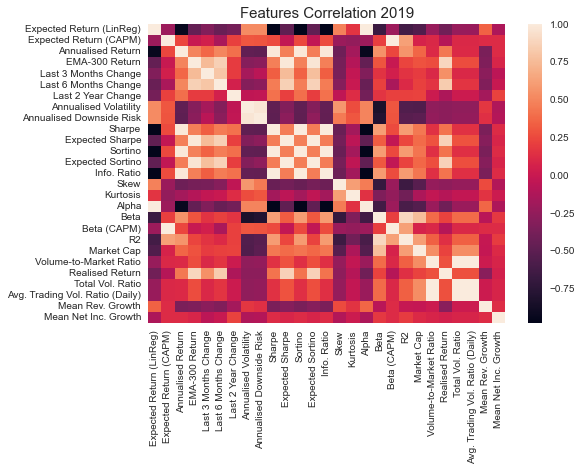

In [179]:
metrics_corr=assets.corr()
sns.heatmap(metrics_corr)
plt.title('Features Correlation 2019', fontsize=15)

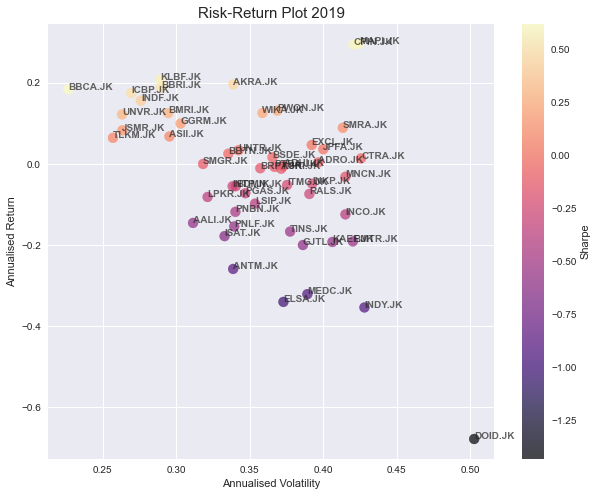

In [180]:
fig, ax = plt.subplots()
Y = 'Annualised Return'
X = 'Annualised Volatility'
C = 'Sharpe'
ax= assets.plot.scatter(x=X, y=Y, c=C, 
                                           cmap= 'magma', marker='.', 
                                           s=400, alpha=0.7, grid=True, 
                                           figsize=[10,8], ax=ax)
ax.set_title('Risk-Return Plot 2019', fontsize=15)
label_point(assets[X], assets[Y], assets.index.to_series(), ax)

In [262]:
arr_scaled = scaler.fit_transform(assets)
assets_scaled = pd.DataFrame(arr_scaled, columns=assets.columns,index=assets.index)
assets_scaled

,Expected Return (LinReg),Expected Return (CAPM),Annualised Return,EMA-300 Return,Last 3 Months Change,Last 6 Months Change,Last 2 Year Change,Annualised Volatility,Annualised Downside Risk,Sharpe,...,Beta,Beta (CAPM),R2,Market Cap,Volume-to-Market Ratio,Realised Return,Total Vol. Ratio,Avg. Trading Vol. Ratio (Daily),Mean Rev. Growth,Mean Net Inc. Growth
AALI.JK,0.7174,0.1632,0.5465,0.8656,0.9287,0.8769,0.3748,0.3072,0.3541,0.4030,...,0.2604,0.1632,0.2551,0.0179,0.0021,0.7115,0.0021,0.0020,0.1598,0.4681
ADHI.JK,0.5280,0.6633,0.6908,0.5554,0.2709,0.2691,0.4036,0.5304,0.4421,0.6352,...,0.2964,0.6633,0.5024,0.0011,0.1122,0.4346,0.1122,0.1121,0.1564,0.5346
ADRO.JK,0.5294,0.7135,0.6996,0.7940,0.5228,0.5680,0.5186,0.6160,0.5961,0.6495,...,0.2432,0.7135,0.4687,0.0514,0.3786,0.6508,0.3786,0.3787,0.1851,0.5133
AKRA.JK,0.2671,0.3301,0.8971,0.6109,0.4280,0.5091,0.3334,0.4063,0.3034,0.9174,...,0.2565,0.3301,0.3279,0.0159,0.0628,0.5222,0.0628,0.0628,0.2595,0.5120
ANTM.JK,0.9110,0.4903,0.4301,0.5446,0.2027,0.3775,0.4468,0.4061,0.3171,0.2639,...,0.3385,0.4903,0.4685,0.0751,0.3373,0.4745,0.3373,0.3373,0.8215,1.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TINS.JK,0.7523,0.6246,0.5246,0.4061,0.2329,0.0452,0.4767,0.5464,0.3936,0.4272,...,0.2650,0.6246,0.4562,0.0117,0.1261,0.2127,0.1261,0.1260,0.6445,0.2201
TLKM.JK,0.3970,0.3391,0.7618,0.6828,0.4562,0.6095,0.4491,0.1100,0.0907,0.7375,...,0.6914,0.3391,0.6547,0.4089,0.6559,0.6014,0.6559,0.6562,0.1801,0.5142
UNTR.JK,0.4728,0.6859,0.7305,0.5400,0.5273,0.2757,0.4435,0.4195,0.4089,0.6845,...,0.4223,0.6859,0.6254,0.0962,0.0224,0.3961,0.0224,0.0223,0.3110,0.5459
UNVR.JK,0.2702,0.3499,0.8210,0.6553,0.4350,0.5909,0.4542,0.1322,0.1089,0.8434,...,0.6522,0.3499,0.6361,0.1916,0.0563,0.5429,0.0563,0.0563,0.1723,0.5265


In [246]:
assets_top_alpha = assets_scaled.sort_values(by='Alpha', ascending = False).head(10)

In [247]:
assets_top_alpha

,Expected Return (LinReg),Expected Return (CAPM),Annualised Return,EMA-300 Return,Last 3 Months Change,Last 6 Months Change,Last 2 Year Change,Annualised Volatility,Annualised Downside Risk,Sharpe,...,Beta,Beta (CAPM),R2,Market Cap,Volume-to-Market Ratio,Realised Return,Total Vol. Ratio,Avg. Trading Vol. Ratio (Daily),Mean Rev. Growth,Mean Net Inc. Growth
DOID.JK,1.0000,0.5800,0.0000,0.3585,0.1373,0.0000,0.3533,1.0000,1.0000,0.0000,...,0.0000,0.5800,0.1513,0.0006,0.2594,0.1736,0.2594,0.2597,0.2315,0.5160
ANTM.JK,0.9110,0.4903,0.4301,0.5446,0.2027,0.3775,0.4468,0.4061,0.3171,0.2639,...,0.3385,0.4903,0.4685,0.0751,0.3373,0.4745,0.3373,0.3373,0.8215,1.0000
INDY.JK,0.8810,0.6426,0.3327,0.4291,0.3072,0.2795,0.1449,0.7296,0.6924,0.2467,...,0.1417,0.6426,0.3388,0.0064,0.1056,0.2712,0.1056,0.1057,1.0000,0.4271
ELSA.JK,0.8375,0.2060,0.3468,0.6026,0.3515,0.3722,0.4165,0.5299,0.4887,0.1978,...,0.1032,0.2060,0.1377,0.0000,0.2884,0.5216,0.2884,0.2886,0.4604,0.5406
GJTL.JK,0.7965,0.5083,0.4906,0.5779,0.4833,0.4822,0.4615,0.5780,0.4573,0.3916,...,0.2017,0.5083,0.3517,0.0007,0.0521,0.4473,0.0521,0.0522,0.2149,0.1771
MEDC.JK,0.8041,0.2071,0.3663,0.5905,0.6364,0.5412,0.0879,0.5889,0.5897,0.2426,...,0.0674,0.2071,0.1011,0.0126,0.2092,0.4878,0.2092,0.2094,0.3975,0.4432
TINS.JK,0.7523,0.6246,0.5246,0.4061,0.2329,0.0452,0.4767,0.5464,0.3936,0.4272,...,0.2650,0.6246,0.4562,0.0117,0.1261,0.2127,0.1261,0.1260,0.6445,0.2201
PNLF.JK,0.7274,0.3177,0.5376,0.6097,0.2217,0.4453,0.5265,0.4086,0.3132,0.4149,...,0.2483,0.3177,0.3138,0.0049,0.2934,0.4586,0.2934,0.2941,0.0933,0.5372
AALI.JK,0.7174,0.1632,0.5465,0.8656,0.9287,0.8769,0.3748,0.3072,0.3541,0.4030,...,0.2604,0.1632,0.2551,0.0179,0.0021,0.7115,0.0021,0.0020,0.1598,0.4681
ISAT.JK,0.7097,0.0782,0.5131,0.4281,0.3301,0.3940,0.0000,0.3849,0.3861,0.3745,...,0.1398,0.0782,0.1122,0.0427,0.0089,0.3986,0.0089,0.0089,0.0999,0.2953


In [248]:
cor_target=abs(metrics_corr['Realised Return'])
relevant_features = cor_target[cor_target>0.4]
relevant_index = relevant_features.index

In [249]:
pd.DataFrame(relevant_index)

,0
0,Expected Return (LinReg)
1,Annualised Return
2,EMA-300 Return
3,Last 3 Months Change
4,Last 6 Months Change
5,Sharpe
6,Expected Sharpe
7,Sortino
8,Expected Sortino
9,Info. Ratio


<AxesSubplot:title={'center':'Stocks Features (Normalised)'}>

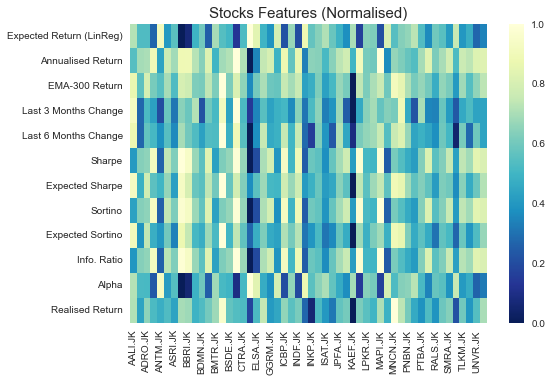

In [250]:
assets_sampled = assets_scaled[relevant_index].T
plt.title('Stocks Features (Normalised)', fontsize=15)
sns.heatmap(assets_sampled,cmap='YlGnBu_r')

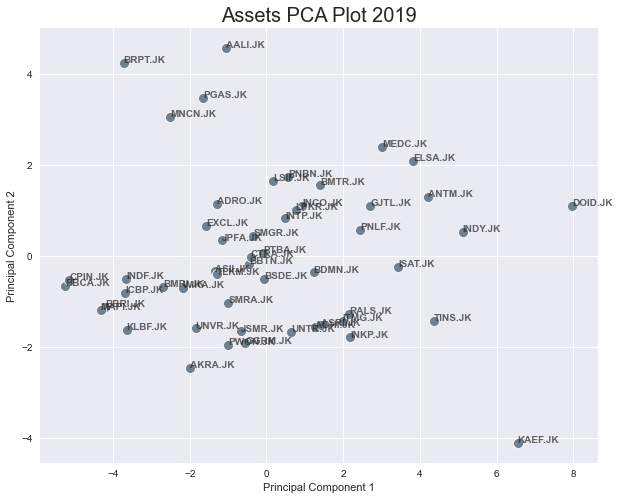

In [187]:
data_plot=getPCA(assets_scaled[relevant_index])
X=data_plot.iloc[:,0]
Y=data_plot.iloc[:,1]

fig, ax = plt.subplots(figsize = [10,8])
sns.set_style('darkgrid')
ax = sns.scatterplot(x=X, y=Y, 
                data=data_plot, s=100, 
                palette='Set1', color='slategray')

ax.set_title('Assets PCA Plot 2019', fontsize=20)
label_point(X, Y,
            data_plot.index.to_series(), ax)

## **K-Means Clustering**

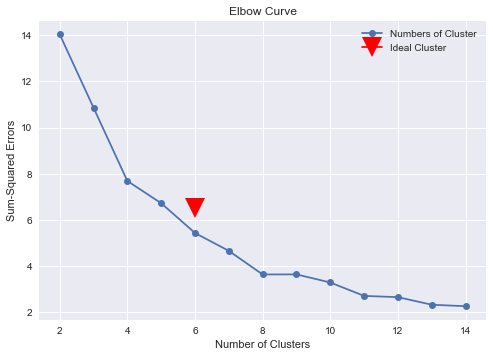

In [188]:
from sklearn.cluster import MiniBatchKMeans


unscaled_X = assets[relevant_index]
scaled_X = scaler.fit_transform(unscaled_X)
scaled_X = pd.DataFrame(scaled_X, columns=unscaled_X.columns, index=unscaled_X.index)

cluster_vars = scaled_X

X = cluster_vars.values 

max_cluster = 15

sse_cluster = []

for k in range(2, max_cluster):
    kmeans =MiniBatchKMeans(n_clusters = k)
    kmeans.fit(X)
    
    sse_cluster.append(kmeans.inertia_)
    
plt.plot(range(2, max_cluster), sse_cluster, marker ='o', label='Numbers of Cluster')
plt.plot(6, 6.5, marker='v', c='r', ms=20, label='Ideal Cluster')
plt.title("Elbow Curve")
plt.xlabel('Number of Clusters')
plt.ylabel('Sum-Squared Errors')
plt.legend()
plt.show()

In [189]:
cluster_vars

,Expected Return (LinReg),Annualised Return,EMA-300 Return,Last 3 Months Change,Last 6 Months Change,Sharpe,Expected Sharpe,Sortino,Expected Sortino,Info. Ratio,Alpha,Realised Return
AALI.JK,0.7174,0.5465,0.8656,0.9287,0.8769,0.4030,0.9261,0.4291,0.9084,0.3916,0.7160,0.7115
ADHI.JK,0.5280,0.6908,0.5554,0.2709,0.2691,0.6352,0.4800,0.6344,0.3867,0.6359,0.5165,0.4346
ADRO.JK,0.5294,0.6996,0.7940,0.5228,0.5680,0.6495,0.7775,0.6511,0.7410,0.6529,0.5145,0.6508
AKRA.JK,0.2671,0.8971,0.6109,0.4280,0.5091,0.9174,0.5549,0.9261,0.4759,0.9190,0.2360,0.5222
ANTM.JK,0.9110,0.4301,0.5446,0.2027,0.3775,0.2639,0.4982,0.2548,0.3974,0.2540,0.9273,0.4745
...,...,...,...,...,...,...,...,...,...,...,...,...
TINS.JK,0.7523,0.5246,0.4061,0.2329,0.0452,0.4272,0.3644,0.4071,0.2727,0.4248,0.7534,0.2127
TLKM.JK,0.3970,0.7618,0.6828,0.4562,0.6095,0.7375,0.6440,0.7362,0.5829,0.7217,0.4028,0.6014
UNTR.JK,0.4728,0.7305,0.5400,0.5273,0.2757,0.6845,0.4636,0.6861,0.3922,0.6825,0.4660,0.3961
UNVR.JK,0.2702,0.8210,0.6553,0.4350,0.5909,0.8434,0.5896,0.8363,0.5307,0.8308,0.2652,0.5429


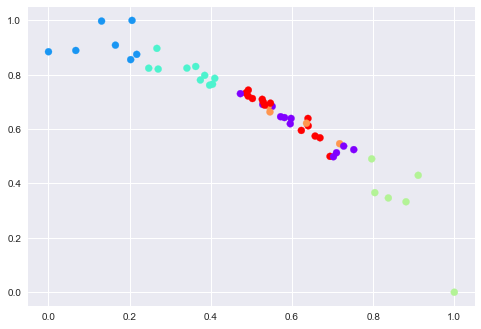

In [190]:
kmeans = MiniBatchKMeans(n_clusters=6, random_state=4567).fit(X)

centroids = kmeans.cluster_centers_

plt.scatter(X[:,0],X[:,1], c = kmeans.labels_, cmap ="rainbow")
plt.show()

In [191]:
kmeans.n_iter_

18

In [192]:
cluster_centroids = pd.DataFrame(centroids)
pca_centroids = getPCA(cluster_centroids)
pca_centroids

,Principal Component 1,Principal Component 2
0,0.4203,-0.3823
1,-0.9197,-0.1512
2,-0.3608,-0.2989
3,1.0441,0.0567
4,-0.2065,0.7115
5,0.0226,0.0642


In [193]:
cluster_labels = pd.DataFrame(kmeans.labels_, index= cluster_vars.index, columns=['Cluster Group'])
cluster_labels

,Cluster Group
AALI.JK,4
ADHI.JK,0
ADRO.JK,5
AKRA.JK,2
ANTM.JK,3
...,...
TINS.JK,0
TLKM.JK,2
UNTR.JK,0
UNVR.JK,2


In [194]:
assets_cluster = pd.concat([assets, cluster_labels], axis=1)

In [195]:
assets_cluster_scaled = pd.concat([assets_scaled, cluster_labels], axis=1)

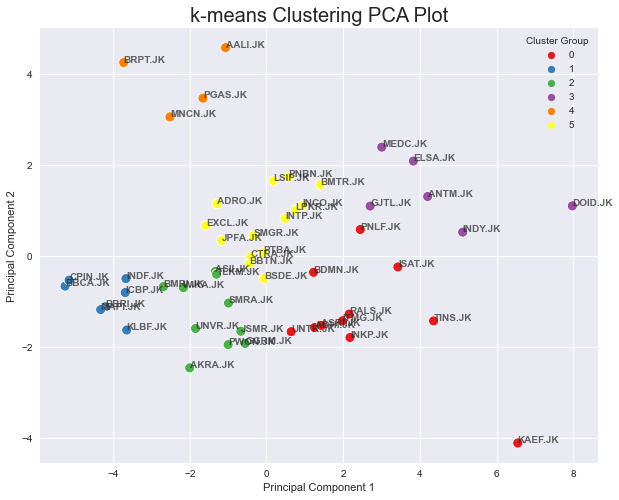

In [196]:
data_plot=getPCA(assets_scaled[relevant_index]).join(cluster_labels)
X=data_plot.iloc[:,0]
Y=data_plot.iloc[:,1]

fig, ax = plt.subplots(figsize = [10,8])
sns.set_style('darkgrid')
ax = sns.scatterplot(x=X, y=Y, 
                data=data_plot, hue='Cluster Group', s=100, 
                palette='Set1')
ax.set_title('k-means Clustering PCA Plot', fontsize=20)
label_point(X, Y,
            data_plot.index.to_series(), ax)

In [197]:
kmeans_mean = assets_cluster.groupby(['Cluster Group']).mean()#.sort_values(by='Ann Returns', ascending=False)
kmeans_mean

,Expected Return (LinReg),Expected Return (CAPM),Annualised Return,EMA-300 Return,Last 3 Months Change,Last 6 Months Change,Last 2 Year Change,Annualised Volatility,Annualised Downside Risk,Sharpe,...,Beta,Beta (CAPM),R2,Market Cap,Volume-to-Market Ratio,Realised Return,Total Vol. Ratio,Avg. Trading Vol. Ratio (Daily),Mean Rev. Growth,Mean Net Inc. Growth
Cluster Group,,,,,,,,,,,,,,,,,,,,,
0,0.0868,0.0667,-0.0825,-0.5473,-0.1937,-0.4388,-0.0673,0.3676,0.2277,-0.3428,...,0.2096,0.7685,0.3994,22086363636363.6367,0.0042,-0.4891,0.0042,0.0042,0.0777,-0.4861
1,0.0069,0.0684,0.2140,0.2003,0.0232,0.0820,0.2207,0.3138,0.1992,0.5384,...,0.3327,0.8236,0.5093,230187142857142.8438,0.0123,0.1568,0.0123,0.0122,0.0731,0.2150
2,0.0413,0.0684,0.1099,-0.0843,-0.1052,-0.1702,-0.1968,0.3157,0.1947,0.2093,...,0.3148,0.8226,0.5022,114729000000000.0000,0.0080,0.0013,0.0080,0.0079,0.0531,0.1103
3,0.1295,0.0665,-0.3587,-0.4224,-0.1615,-0.3642,-0.4237,0.4031,0.2472,-0.9744,...,0.1771,0.7623,0.3636,14766666666666.6660,0.0081,-0.3525,0.0081,0.0081,0.3565,-0.0418
4,0.0856,0.0639,-0.0653,0.5459,0.1639,0.2449,-0.3174,0.3578,0.2271,-0.3182,...,0.1961,0.6757,0.3613,36722500000000.0000,0.0086,0.5834,0.0086,0.0085,0.0166,-0.2200
5,0.0795,0.0686,-0.0384,-0.0504,-0.0150,-0.0692,-0.2683,0.3708,0.2302,-0.2217,...,0.2257,0.8304,0.4299,25599285714285.7148,0.0061,-0.0023,0.0061,0.0061,0.0625,-0.7232


In [198]:
# actual_return = pd.DataFrame(columns= ['Actual Return (2020)'])
# for x in kmeans_mean.index:
#     sel = assets_cluster[assets_cluster['Cluster Group'] == x]
#     weights = np.ones(len(sel)) / len(sel)
#     actual_return.loc[x]=ret_2020[sel.index].dot(weights)

In [199]:
# kmeans_mean = kmeans_mean.join(actual_return)

In [200]:
kmeans_mean

,Expected Return (LinReg),Expected Return (CAPM),Annualised Return,EMA-300 Return,Last 3 Months Change,Last 6 Months Change,Last 2 Year Change,Annualised Volatility,Annualised Downside Risk,Sharpe,...,Beta,Beta (CAPM),R2,Market Cap,Volume-to-Market Ratio,Realised Return,Total Vol. Ratio,Avg. Trading Vol. Ratio (Daily),Mean Rev. Growth,Mean Net Inc. Growth
Cluster Group,,,,,,,,,,,,,,,,,,,,,
0,0.0868,0.0667,-0.0825,-0.5473,-0.1937,-0.4388,-0.0673,0.3676,0.2277,-0.3428,...,0.2096,0.7685,0.3994,22086363636363.6367,0.0042,-0.4891,0.0042,0.0042,0.0777,-0.4861
1,0.0069,0.0684,0.2140,0.2003,0.0232,0.0820,0.2207,0.3138,0.1992,0.5384,...,0.3327,0.8236,0.5093,230187142857142.8438,0.0123,0.1568,0.0123,0.0122,0.0731,0.2150
2,0.0413,0.0684,0.1099,-0.0843,-0.1052,-0.1702,-0.1968,0.3157,0.1947,0.2093,...,0.3148,0.8226,0.5022,114729000000000.0000,0.0080,0.0013,0.0080,0.0079,0.0531,0.1103
3,0.1295,0.0665,-0.3587,-0.4224,-0.1615,-0.3642,-0.4237,0.4031,0.2472,-0.9744,...,0.1771,0.7623,0.3636,14766666666666.6660,0.0081,-0.3525,0.0081,0.0081,0.3565,-0.0418
4,0.0856,0.0639,-0.0653,0.5459,0.1639,0.2449,-0.3174,0.3578,0.2271,-0.3182,...,0.1961,0.6757,0.3613,36722500000000.0000,0.0086,0.5834,0.0086,0.0085,0.0166,-0.2200
5,0.0795,0.0686,-0.0384,-0.0504,-0.0150,-0.0692,-0.2683,0.3708,0.2302,-0.2217,...,0.2257,0.8304,0.4299,25599285714285.7148,0.0061,-0.0023,0.0061,0.0061,0.0625,-0.7232


In [201]:
kmeans_scaled = scaler.fit_transform(kmeans_mean)
kmeans_mean_scaled = pd.DataFrame(kmeans_scaled, columns=assets.columns,index=kmeans_mean.index)

In [202]:
kmeans_mean_scaled

,Expected Return (LinReg),Expected Return (CAPM),Annualised Return,EMA-300 Return,Last 3 Months Change,Last 6 Months Change,Last 2 Year Change,Annualised Volatility,Annualised Downside Risk,Sharpe,...,Beta,Beta (CAPM),R2,Market Cap,Volume-to-Market Ratio,Realised Return,Total Vol. Ratio,Avg. Trading Vol. Ratio (Daily),Mean Rev. Growth,Mean Net Inc. Growth
Cluster Group,,,,,,,,,,,,,,,,,,,,,
0,0.6518,0.5998,0.4823,0.0000,0.0000,0.0000,0.5531,0.6022,0.6279,0.4175,...,0.2094,0.5998,0.2573,0.0340,0.0000,0.0000,0.0000,0.0000,0.1797,0.2527
1,0.0000,0.9560,1.0000,0.6839,0.6066,0.7618,1.0000,0.0000,0.0856,1.0000,...,1.0000,0.9560,1.0000,1.0000,1.0000,0.6022,1.0000,1.0000,0.1661,1.0000
2,0.2801,0.9492,0.8182,0.4236,0.2474,0.3929,0.3522,0.0215,0.0000,0.7825,...,0.8852,0.9492,0.9526,0.4640,0.4634,0.4572,0.4634,0.4637,0.1075,0.8884
3,1.0000,0.5598,0.0000,0.1142,0.0901,0.1091,0.0000,1.0000,1.0000,0.0000,...,0.0000,0.5598,0.0158,0.0000,0.4833,0.1274,0.4833,0.4837,1.0000,0.7263
4,0.6420,0.0000,0.5123,1.0000,1.0000,1.0000,0.1650,0.4930,0.6172,0.4338,...,0.1221,0.0000,0.0000,0.1019,0.5390,1.0000,0.5390,0.5393,0.0000,0.5363
5,0.5920,1.0000,0.5592,0.4546,0.4998,0.5405,0.2412,0.6383,0.6768,0.4976,...,0.3125,1.0000,0.4637,0.0503,0.2325,0.4539,0.2325,0.2323,0.1351,0.0000


Text(0.5, 1.0, "Normalised Means of Clusters' Features")

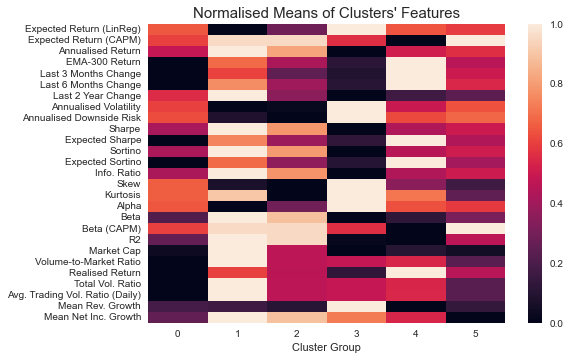

In [203]:
sns.heatmap(kmeans_mean_scaled.T)
plt.title('Normalised Means of Clusters\' Features', fontsize=15)

In [204]:
cluster_method= assets_cluster
cluster_mean = kmeans_mean

In [205]:
# data_plot=assets_cluster
# X='EMA-300 Return'
# Y='Annualised Volatility'

# fig, ax = plt.subplots(figsize = [10,8])
# sns.set_style('darkgrid')
# ax = sns.scatterplot(x=X, y=Y, 
#                 data=data_plot, 
#                 hue='Cluster Group', s=100, 
#                 palette='Set1')
# ax.set_title('K-Means Analysis Plot: Expected Returns vs Mean Volatility (Normalised)', fontsize=20)
# label_point(data_plot[X], data_plot[Y],
#             data_plot.index.to_series(), ax)

In [206]:
cluster_method= assets_cluster
cluster_mean = kmeans_mean
picking_param = 'Alpha'
kmeans_portfolio=pd.DataFrame()
# for cluster in cluster_mean.index:
#     kmeans_portfolio=kmeans_portfolio.append(cluster_method[cluster_method['Cluster Group']==cluster].sort_values(by=picking_param, ascending=False).iloc[0])

In [207]:
pd.Series(cluster_method[cluster_method['Cluster Group']==4].index).to_clipboard()

In [208]:
kmeans_portfolio = cluster_method[cluster_method['Cluster Group']==cluster_mean[picking_param].idxmax()]

## **Agglomerative Clustering**

In [209]:
from sklearn.cluster import AgglomerativeClustering

assets_input = assets_scaled

assets_dist = pd.DataFrame(pairwise_distances(assets_input), index=assets_input.index, columns=assets_input.index).round(4)

assets_agg = assets_dist
assets_agg

,AALI.JK,ADHI.JK,ADRO.JK,AKRA.JK,ANTM.JK,ASII.JK,ASRI.JK,BBCA.JK,BBRI.JK,BBTN.JK,...,PTBA.JK,PWON.JK,RALS.JK,SMGR.JK,SMRA.JK,TINS.JK,TLKM.JK,UNTR.JK,UNVR.JK,WIKA.JK
AALI.JK,0.0000,8.0275,6.6224,7.5823,9.5539,7.8139,8.7961,11.2971,12.8214,6.4388,...,6.2960,8.5978,7.4952,5.7878,7.9391,9.9893,8.7520,7.8369,7.2476,7.1059
ADHI.JK,8.0275,0.0000,4.8775,4.5077,7.1251,5.2808,3.2510,11.3809,11.0038,3.5964,...,4.0612,3.8135,3.9169,3.6883,3.5231,5.0052,7.8434,3.2438,5.3229,3.8798
ADRO.JK,6.6224,4.8775,0.0000,5.8315,8.1497,4.8322,4.4618,9.7608,8.5369,4.0816,...,4.0738,3.5576,6.6028,4.5323,3.5162,7.9465,6.2960,5.2575,6.3032,3.9403
AKRA.JK,7.5823,4.5077,5.8315,0.0000,9.3157,5.5899,5.6846,9.7747,10.6067,4.3330,...,4.9604,4.2324,4.9994,4.3081,4.4218,7.7828,7.2457,4.4526,3.5329,3.3187
ANTM.JK,9.5539,7.1251,8.1497,9.3157,0.0000,8.7403,7.1427,13.3869,12.7345,7.7337,...,7.8849,8.1321,7.4017,7.1010,8.6485,7.1127,9.4429,7.8008,9.3682,8.6705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TINS.JK,9.9893,5.0052,7.9465,7.7828,7.1127,8.2197,5.8924,13.8632,13.3274,6.5075,...,6.6115,7.1752,5.6505,6.5799,7.3068,0.0000,10.1514,6.0218,8.5665,7.6748
TLKM.JK,8.7520,7.8434,6.2960,7.2457,9.4429,5.1139,6.3595,6.0893,5.6917,6.4067,...,7.4025,5.7434,8.9766,6.7674,7.6670,10.1514,0.0000,7.3626,5.7268,7.0800
UNTR.JK,7.8369,3.2438,5.2575,4.4526,7.8008,4.0537,4.9606,10.3912,10.6483,2.9590,...,3.8892,3.8349,5.2281,3.1144,3.5126,6.0218,7.3626,0.0000,4.5834,4.5502
UNVR.JK,7.2476,5.3229,6.3032,3.5329,9.3682,3.7909,6.3349,7.6304,9.5193,4.3077,...,5.3191,5.0350,6.5332,3.7831,5.6968,8.5665,5.7268,4.5834,0.0000,4.2102


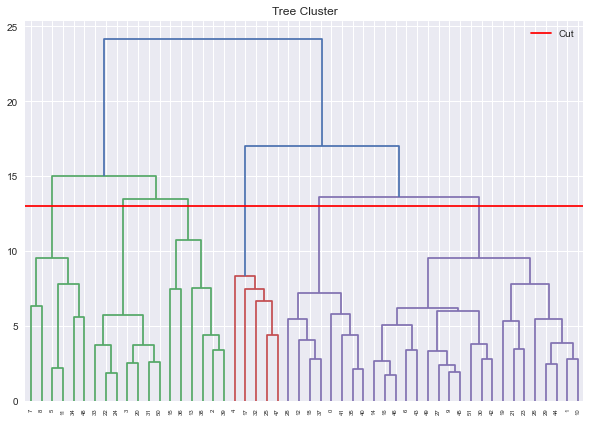

In [210]:
from scipy.cluster.hierarchy import dendrogram, linkage
plt.figure(figsize=(10, 7))  
plt.title('Tree Cluster')
plt.axhline(y=13, color='r', linestyle='-', label='Cut')
plt.legend()
cond_assets_dist = pdist(assets_input)
dend = dendrogram(linkage(cond_assets_dist, method='ward'))

In [211]:
X_agg = assets_agg.values

In [212]:
agg_clus = AgglomerativeClustering(n_clusters=6, linkage='ward').fit(X_agg)

/Users/rizz/opt/anaconda3/envs/mlstocks/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


In [213]:
cluster_labels_agg = pd.DataFrame(agg_clus.labels_, index= assets.index, columns=['Cluster Group'])
assets_scaled_cluster_agg = pd.concat([assets_scaled, cluster_labels_agg], axis=1)
assets_scaled_cluster_agg #.sort_values(by='Annualised Returns', ascending=False).head(10)

,Expected Return (LinReg),Expected Return (CAPM),Annualised Return,EMA-300 Return,Last 3 Months Change,Last 6 Months Change,Last 2 Year Change,Annualised Volatility,Annualised Downside Risk,Sharpe,...,Beta (CAPM),R2,Market Cap,Volume-to-Market Ratio,Realised Return,Total Vol. Ratio,Avg. Trading Vol. Ratio (Daily),Mean Rev. Growth,Mean Net Inc. Growth,Cluster Group
AALI.JK,0.9076,-1.5093,-0.6907,1.4815,2.1585,1.7040,-0.3381,-0.7929,-0.3213,-0.9856,...,-1.5093,-0.8394,-0.3906,-0.9221,1.0055,-0.9221,-0.9222,-0.5250,-0.2070,2
ADHI.JK,0.0451,0.7857,0.1085,-0.5273,-1.0946,-1.1996,-0.1864,0.3428,0.1225,0.0584,...,0.7857,0.2944,-0.4900,-0.3737,-0.5202,-0.3737,-0.3747,-0.5448,0.2902,4
ADRO.JK,0.0514,1.0158,0.1571,1.0176,0.1512,0.2285,0.4185,0.7785,0.8985,0.1225,...,1.0158,0.1401,-0.1921,0.9526,0.6709,0.9526,0.9525,-0.3782,0.1312,1
AKRA.JK,-1.1426,-0.7433,1.2506,-0.1679,-0.3177,-0.0528,-0.5557,-0.2885,-0.5771,1.3272,...,-0.7433,-0.5053,-0.4024,-0.6196,-0.0374,-0.6196,-0.6198,0.0537,0.1216,1
ANTM.JK,1.7891,-0.0084,-1.3351,-0.5973,-1.4319,-0.6813,0.0408,-0.2900,-0.5079,-1.6109,...,-0.0084,0.1392,-0.0511,0.7472,-0.3003,0.7472,0.7465,3.3173,3.7724,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TINS.JK,1.0663,0.6078,-0.8117,-1.4937,-1.2826,-2.2692,0.1983,0.4243,-0.1222,-0.8767,...,0.6078,0.0827,-0.4271,-0.3046,-1.7427,-0.3046,-0.3052,2.2892,-2.0629,0
TLKM.JK,-0.5512,-0.7020,0.5013,0.2976,-0.1782,0.4267,0.0530,-1.7965,-1.6491,0.5184,...,-0.7020,0.9927,1.9294,2.3336,0.3990,2.3336,2.3335,-0.4075,0.1374,5
UNTR.JK,-0.2060,0.8890,0.3283,-0.6266,0.1732,-1.1679,0.0231,-0.2216,-0.0450,0.2800,...,0.8890,0.8584,0.0742,-0.8210,-0.7323,-0.8210,-0.8213,0.3528,0.3750,1
UNVR.JK,-1.1283,-0.6524,0.8293,0.1200,-0.2833,0.3378,0.0794,-1.6834,-1.5576,0.9941,...,-0.6524,0.9072,0.6401,-0.6518,0.0769,-0.6518,-0.6523,-0.4526,0.2300,1


In [214]:
assets_cluster_agg = pd.concat([assets, cluster_labels_agg], axis=1)
assets_cluster_agg

,Expected Return (LinReg),Expected Return (CAPM),Annualised Return,EMA-300 Return,Last 3 Months Change,Last 6 Months Change,Last 2 Year Change,Annualised Volatility,Annualised Downside Risk,Sharpe,...,Beta (CAPM),R2,Market Cap,Volume-to-Market Ratio,Realised Return,Total Vol. Ratio,Avg. Trading Vol. Ratio (Daily),Mean Rev. Growth,Mean Net Inc. Growth,Cluster Group
AALI.JK,0.1036,0.0613,-0.1457,0.4429,0.2247,0.2601,-0.3042,0.3116,0.2105,-0.6065,...,0.5916,0.3624,16360000000000.0000,0.0004,0.2975,0.0004,0.0004,0.0086,-0.5611,2
ADHI.JK,0.0718,0.0708,-0.0052,-0.3276,-0.2166,-0.4494,-0.2430,0.3732,0.2242,-0.1297,...,0.9011,0.4606,2920000000000.0000,0.0045,-0.2730,0.0045,0.0045,0.0054,0.1401,4
ADRO.JK,0.0721,0.0717,0.0034,0.2650,-0.0476,-0.1005,0.0008,0.3968,0.2480,-0.1005,...,0.9321,0.4472,43180000000000.0000,0.0145,0.1724,0.0145,0.0144,0.0330,-0.0840,1
AKRA.JK,0.0281,0.0645,0.1956,-0.1897,-0.1112,-0.1692,-0.3920,0.3389,0.2027,0.4497,...,0.6949,0.3913,14760000000000.0000,0.0026,-0.0925,0.0026,0.0026,0.1046,-0.0976,1
ANTM.JK,0.1361,0.0675,-0.2590,-0.3544,-0.2624,-0.3228,-0.1514,0.3388,0.2048,-0.8920,...,0.7940,0.4472,62240000000000.0000,0.0129,-0.1908,0.0129,0.0129,0.6460,5.0516,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TINS.JK,0.1095,0.0700,-0.1670,-0.6983,-0.2421,-0.7108,-0.0879,0.3776,0.2167,-0.5567,...,0.8771,0.4423,11430000000000.0000,0.0050,-0.7302,0.0050,0.0050,0.4754,-3.1787,0
TLKM.JK,0.0499,0.0646,0.0639,-0.0112,-0.0923,-0.0521,-0.1465,0.2571,0.1698,0.0803,...,0.7005,0.5211,329880000000000.0000,0.0249,0.0707,0.0249,0.0248,0.0281,-0.0754,5
UNTR.JK,0.0626,0.0712,0.0335,-0.3657,-0.0446,-0.4417,-0.1586,0.3426,0.2190,-0.0285,...,0.9150,0.5095,79170000000000.0000,0.0011,-0.3524,0.0011,0.0011,0.1543,0.2598,1
UNVR.JK,0.0286,0.0648,0.1216,-0.0793,-0.1066,-0.0738,-0.1359,0.2632,0.1726,0.2976,...,0.7072,0.5137,155650000000000.0000,0.0024,-0.0498,0.0024,0.0024,0.0207,0.0553,1


<AxesSubplot:title={'center':'Distance Matrix'}>

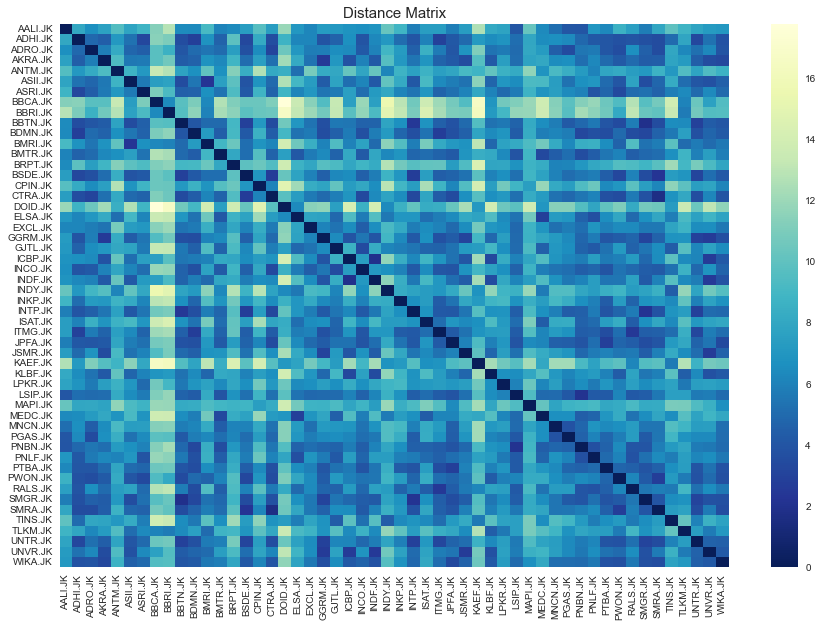

In [251]:
plt.subplots(figsize=(15,10))
plt.title('Distance Matrix', fontsize=15)
sns.heatmap(assets_dist, cmap='YlGnBu_r')

<AxesSubplot:>

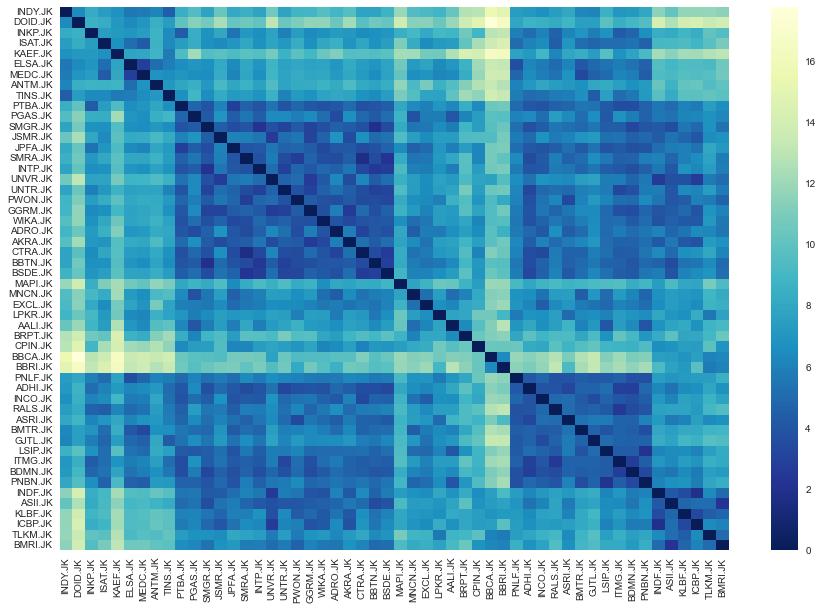

In [216]:
plt.subplots(figsize=(15,10))
sortIx = assets_cluster_agg.sort_values(by='Cluster Group').index
sns.heatmap(assets_dist.loc[sortIx, sortIx], cmap='YlGnBu_r')

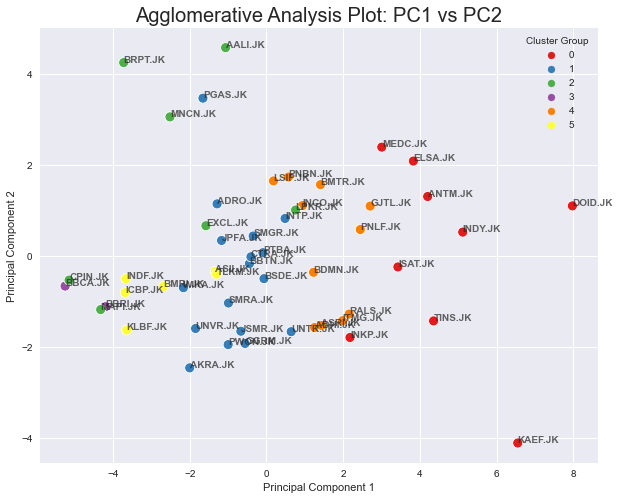

In [217]:
data_plot=getPCA(assets_scaled[relevant_index]).join(cluster_labels_agg)
X=data_plot.iloc[:,0]
Y=data_plot.iloc[:,1]

fig, ax = plt.subplots(figsize = [10,8])
sns.set_style('darkgrid')
ax = sns.scatterplot(x=X, y=Y, 
                data=data_plot, hue='Cluster Group', s=100, 
                palette='Set1')
ax.set_title('Agglomerative Analysis Plot: PC1 vs PC2', fontsize=20)
label_point(X, Y,
            data_plot.index.to_series(), ax)

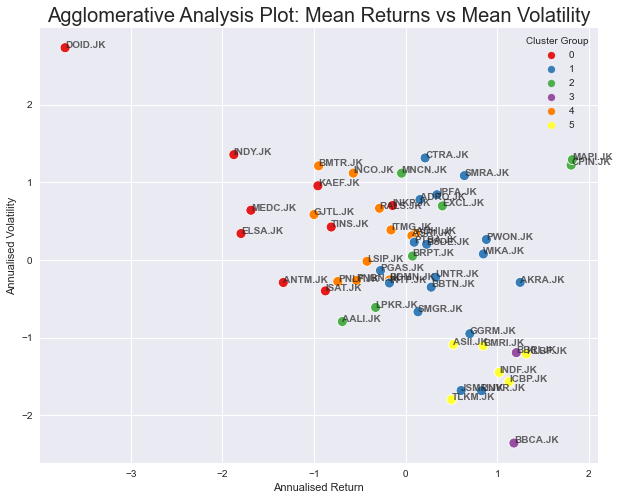

In [218]:
data_plot=assets_scaled_cluster_agg
X= 'Annualised Return'
Y= 'Annualised Volatility'

fig, ax = plt.subplots(figsize = [10,8])
sns.set_style('darkgrid')
ax = sns.scatterplot(x=X, y=Y, 
                data=data_plot, hue='Cluster Group', s=100, 
                palette='Set1')
ax.set_title('Agglomerative Analysis Plot: Mean Returns vs Mean Volatility', fontsize=20)
label_point(data_plot[X], data_plot[Y],
            data_plot.index.to_series(), ax)

In [219]:
cluster_agg_mean = assets_cluster_agg.groupby(['Cluster Group']).mean() #.sort_values(by='Alpha', ascending=False)
cluster_agg_mean

,Expected Return (LinReg),Expected Return (CAPM),Annualised Return,EMA-300 Return,Last 3 Months Change,Last 6 Months Change,Last 2 Year Change,Annualised Volatility,Annualised Downside Risk,Sharpe,...,Beta,Beta (CAPM),R2,Market Cap,Volume-to-Market Ratio,Realised Return,Total Vol. Ratio,Avg. Trading Vol. Ratio (Daily),Mean Rev. Growth,Mean Net Inc. Growth
Cluster Group,,,,,,,,,,,,,,,,,,,,,
0,0.1169,0.0659,-0.2821,-0.6488,-0.1956,-0.4719,-0.3282,0.3935,0.2446,-0.8060,...,0.1784,0.7424,0.3604,21102222222222.2227,0.0061,-0.5730,0.0061,0.0060,0.3073,-0.2775
1,0.0600,0.0694,0.0490,-0.0831,-0.0451,-0.1433,-0.1845,0.3498,0.2169,0.0239,...,0.2624,0.8549,0.4686,38304117647058.8203,0.0051,-0.0339,0.0051,0.0051,0.0671,0.1079
2,0.0617,0.0665,0.0521,0.3018,0.1021,0.1863,-0.1646,0.3776,0.2365,-0.0187,...,0.1962,0.7597,0.3822,40218571428571.4297,0.0086,0.3642,0.0086,0.0085,0.0397,-1.2219
3,-0.0111,0.0690,0.1859,0.2450,0.0134,-0.0087,0.1274,0.2583,0.1727,0.5596,...,0.4664,0.8436,0.6198,633585000000000.0000,0.0281,0.2438,0.0281,0.0280,0.1127,0.0980
4,0.0903,0.0665,-0.0987,-0.2208,-0.1397,-0.2363,-0.1484,0.3734,0.2267,-0.3793,...,0.2010,0.7602,0.3888,13121818181818.1816,0.0050,-0.1679,0.0050,0.0050,0.0173,-0.4904
5,0.0289,0.0675,0.1321,0.0934,-0.0367,-0.0220,-0.0185,0.2803,0.1796,0.3164,...,0.3676,0.7939,0.5374,176883333333333.3438,0.0113,0.0768,0.0113,0.0113,0.0631,0.0701


In [220]:
agg_scaled = scaler.fit_transform(cluster_agg_mean)
agg_mean_scaled = pd.DataFrame(agg_scaled, columns=cluster_agg_mean.columns,index=cluster_agg_mean.index)

In [221]:
agg_mean_scaled

,Expected Return (LinReg),Expected Return (CAPM),Annualised Return,EMA-300 Return,Last 3 Months Change,Last 6 Months Change,Last 2 Year Change,Annualised Volatility,Annualised Downside Risk,Sharpe,...,Beta,Beta (CAPM),R2,Market Cap,Volume-to-Market Ratio,Realised Return,Total Vol. Ratio,Avg. Trading Vol. Ratio (Daily),Mean Rev. Growth,Mean Net Inc. Growth
Cluster Group,,,,,,,,,,,,,,,,,,,,,
0,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,...,0.0000,0.0000,0.0000,0.0129,0.0460,0.0000,0.0460,0.0458,1.0000,0.7102
1,0.5553,1.0000,0.7075,0.5951,0.5053,0.4993,0.3156,0.6770,0.6150,0.6077,...,0.2915,1.0000,0.4170,0.0406,0.0043,0.5752,0.0043,0.0040,0.1716,1.0000
2,0.5689,0.1542,0.7142,1.0000,1.0000,1.0000,0.3591,0.8823,0.8875,0.5765,...,0.0616,0.1542,0.0840,0.0437,0.1541,1.0000,0.1541,0.1541,0.0771,0.0000
3,0.0000,0.8992,1.0000,0.9402,0.7018,0.7037,1.0000,0.0000,0.0000,1.0000,...,1.0000,0.8992,1.0000,1.0000,1.0000,0.8715,1.0000,1.0000,0.3291,0.9926
4,0.7925,0.1584,0.3918,0.4503,0.1878,0.3579,0.3946,0.8509,0.7516,0.3125,...,0.0784,0.1584,0.1094,0.0000,0.0000,0.4323,0.0000,0.0000,0.0000,0.5501
5,0.3127,0.4580,0.8851,0.7808,0.5335,0.6836,0.6798,0.1628,0.0956,0.8219,...,0.6571,0.4580,0.6823,0.2639,0.2721,0.6933,0.2721,0.2722,0.1580,0.9716


In [222]:
assets_scaled_cluster_agg.groupby(['Cluster Group']).var()

,Expected Return (LinReg),Expected Return (CAPM),Annualised Return,EMA-300 Return,Last 3 Months Change,Last 6 Months Change,Last 2 Year Change,Annualised Volatility,Annualised Downside Risk,Sharpe,...,Beta,Beta (CAPM),R2,Market Cap,Volume-to-Market Ratio,Realised Return,Total Vol. Ratio,Avg. Trading Vol. Ratio (Daily),Mean Rev. Growth,Mean Net Inc. Growth
Cluster Group,,,,,,,,,,,,,,,,,,,,,
0,0.3426,0.8712,1.0248,1.3685,0.9067,0.7945,2.3670,0.8773,1.1293,0.5642,...,0.2234,0.8712,0.4347,0.0243,0.3814,1.1198,0.3814,0.3815,3.0745,2.6642
1,0.2605,0.6925,0.1641,0.2429,0.6241,0.3385,0.6760,0.7260,0.7272,0.2146,...,0.3750,0.6925,0.2435,0.0701,0.3284,0.2990,0.3284,0.3287,0.3208,0.0287
2,0.9891,2.1892,1.0016,0.7041,0.9145,0.3063,2.1583,0.7722,0.6290,1.0230,...,0.2480,2.1892,0.7362,0.0994,1.5556,0.9739,1.5556,1.5564,0.2594,2.6923
3,0.0469,1.9260,0.0003,0.0151,0.0464,0.1020,0.0372,0.6767,0.6105,0.0340,...,0.4918,1.9260,0.1260,3.1710,3.2945,0.0055,3.2945,3.2993,0.0001,0.0001
4,0.1326,0.6159,0.1419,0.2585,0.4907,0.4652,0.5403,0.2759,0.2968,0.1396,...,0.1263,0.6159,0.3088,0.0120,0.4864,0.3209,0.4864,0.4888,0.1949,0.8891
5,0.2198,1.3063,0.1090,0.0382,0.1508,0.2180,0.0964,0.0806,0.0680,0.2036,...,0.3190,1.3063,0.9188,0.7718,1.2624,0.0521,1.2624,1.2619,0.0202,0.0038


In [223]:
# actual_return = pd.DataFrame(columns= ['Actual Return (2020)'])
# for x in cluster_pca_mean.index:
#     sel = assets_scaled_cluster_pca[assets_scaled_cluster_pca['Cluster Group'] == x]
#     weights = np.ones(len(sel)) / len(sel)
#     actual_return.loc[x]=ret_2020[sel.index].dot(weights)

In [224]:
# actual_return_sort=actual_return.sort_values(by='Actual Return (2020)', ascending=False)
# actual_return_sort

In [225]:
agg_cluster_mean = agg_mean_scaled#.join(actual_return)#.sort_values(by='Alpha', ascending=False)
agg_cluster_mean

,Expected Return (LinReg),Expected Return (CAPM),Annualised Return,EMA-300 Return,Last 3 Months Change,Last 6 Months Change,Last 2 Year Change,Annualised Volatility,Annualised Downside Risk,Sharpe,...,Beta,Beta (CAPM),R2,Market Cap,Volume-to-Market Ratio,Realised Return,Total Vol. Ratio,Avg. Trading Vol. Ratio (Daily),Mean Rev. Growth,Mean Net Inc. Growth
Cluster Group,,,,,,,,,,,,,,,,,,,,,
0,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,1.0000,0.0000,...,0.0000,0.0000,0.0000,0.0129,0.0460,0.0000,0.0460,0.0458,1.0000,0.7102
1,0.5553,1.0000,0.7075,0.5951,0.5053,0.4993,0.3156,0.6770,0.6150,0.6077,...,0.2915,1.0000,0.4170,0.0406,0.0043,0.5752,0.0043,0.0040,0.1716,1.0000
2,0.5689,0.1542,0.7142,1.0000,1.0000,1.0000,0.3591,0.8823,0.8875,0.5765,...,0.0616,0.1542,0.0840,0.0437,0.1541,1.0000,0.1541,0.1541,0.0771,0.0000
3,0.0000,0.8992,1.0000,0.9402,0.7018,0.7037,1.0000,0.0000,0.0000,1.0000,...,1.0000,0.8992,1.0000,1.0000,1.0000,0.8715,1.0000,1.0000,0.3291,0.9926
4,0.7925,0.1584,0.3918,0.4503,0.1878,0.3579,0.3946,0.8509,0.7516,0.3125,...,0.0784,0.1584,0.1094,0.0000,0.0000,0.4323,0.0000,0.0000,0.0000,0.5501
5,0.3127,0.4580,0.8851,0.7808,0.5335,0.6836,0.6798,0.1628,0.0956,0.8219,...,0.6571,0.4580,0.6823,0.2639,0.2721,0.6933,0.2721,0.2722,0.1580,0.9716


Text(0.5, 1.0, "Normalised Means of Clusters' Features")

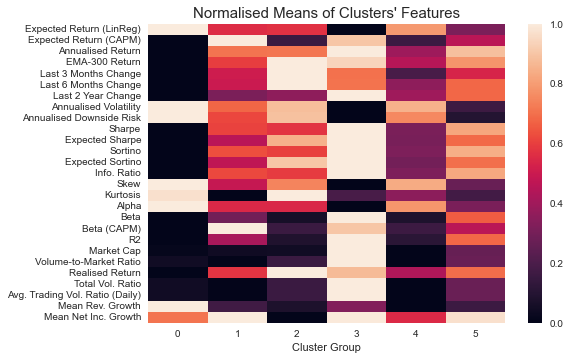

In [226]:
sns.heatmap(agg_cluster_mean.T)
plt.title('Normalised Means of Clusters\' Features', fontsize=15)

<AxesSubplot:>

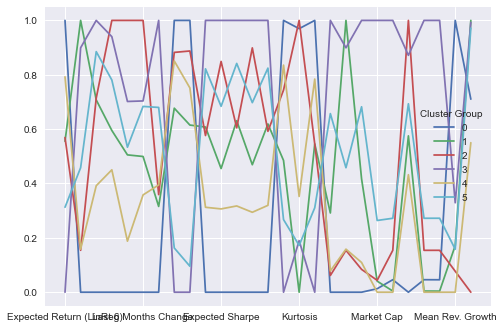

In [227]:
agg_cluster_mean.T.plot()

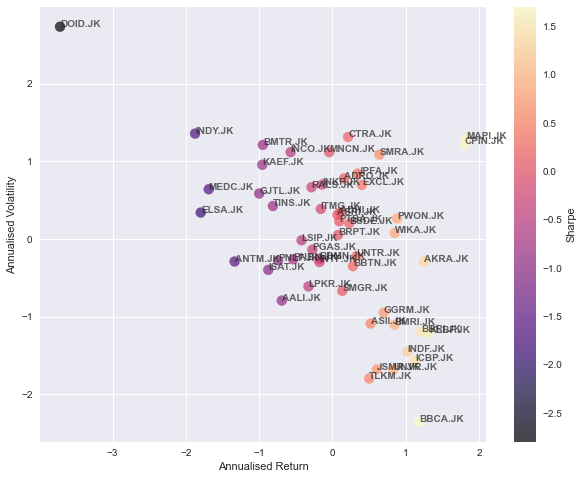

In [228]:
fig, ax = plt.subplots()
data_plot = assets_scaled
X = 'Annualised Return'
Y = 'Annualised Volatility'
C = 'Sharpe'
ax= data_plot.plot.scatter(x=X, y=Y, c=C, 
                                           cmap= 'magma', marker='.', 
                                           s=400, alpha=0.7, grid=True, 
                                           figsize=[10,8], ax=ax)
label_point(data_plot[X], data_plot[Y], assets.index.to_series(), ax)

In [229]:
cluster_method= assets_cluster_agg
cluster_mean = agg_cluster_mean
picking_param = 'Alpha'
agg_portfolio=pd.DataFrame()
# for cluster in cluster_mean.index:
#     pca_portfolio=pca_portfolio.append(cluster_method[cluster_method['Cluster Group']==cluster].sort_values(by=picking_param, ascending=False).iloc[0])

In [230]:
pca_portfolio=cluster_method[cluster_method['Cluster Group']==cluster_mean[picking_param].idxmax()]

# **Hierchical Risk Parity**

In [231]:
import scipy.cluster.hierarchy as sch

class HRPRes:
    def __init__(self, cov, corr, dist, link):
        self.cov = cov
        self.corr = corr
        self.dist = dist
        self.link = link

def HRP(assets_returns):
    rets = assets_returns

    ewm_cov = rets.ewm(span=300).cov()
    cov = ewm_cov.loc[ewm_cov.index.levels[0][-1]]

    ewm_corr = rets.ewm(span=300).corr()
    corr = ewm_corr.loc[ewm_corr.index.levels[0][-1]]

    dist=((1-corr)/2.)**.5

    link=sch.linkage(dist, 'single')
    
    return HRPRes(cov=cov, corr=corr, dist=dist, link=link)

In [232]:
def getIVP(cov, **kargs):
    # Compute the inverse-variance portfolio
    ivp = 1. / np.diag(cov)
    ivp /= ivp.sum()
    return ivp

def getClusterVar(cov,cItems):
    # Compute variance per cluster
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar

def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
        df0 = sortIx[sortIx >= numItems]  # find clusters
        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = sortIx.append(df0)  # item 2
        sortIx = sortIx.sort_index()  # re-sort
        sortIx.index = range(sortIx.shape[0])  # re-index
    return sortIx.tolist()

def getRecBipart(cov, sortIx):
    # Compute HRP alloc
    w = pd.Series(1, index=sortIx)
    cItems = [sortIx]  # initialize all items in one cluster
    while len(cItems) > 0:
        cItems = [i[j:k] for i in cItems for j, k in ((0, len(i) // 2), (len(i) // 2, len(i))) if len(i) > 1]  # bi-section
        for i in range(0, len(cItems), 2):  # parse in pairs
            cItems0 = cItems[i]  # cluster 1
            cItems1 = cItems[i + 1]  # cluster 2
            cVar0 = getClusterVar(cov, cItems0)
            cVar1 = getClusterVar(cov, cItems1)
            alpha = 1 - cVar0 / (cVar0 + cVar1)
            w[cItems0] *= alpha  # weight 1
            w[cItems1] *= 1 - alpha  # weight 2
    return w

In [233]:
def getHRP(assets_rets):
    if len(assets_rets.columns)<2:
        return pd.Series(1.0, index=assets_rets.columns)
    else:
        HRPres = HRP(assets_rets)
        sortIx=getQuasiDiag(HRPres.link)
        sortIx = HRPres.corr.index[sortIx].tolist()
        return getRecBipart(HRPres.cov, sortIx)

<AxesSubplot:>

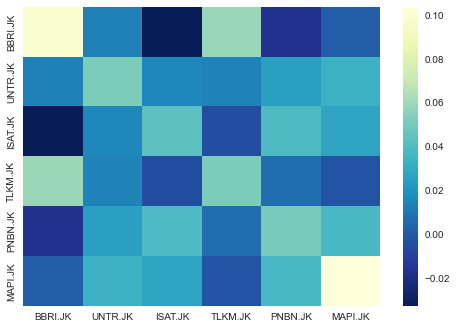

In [305]:
sample_ret = assets_scaled.T.sample(n=6, axis=1)
sample_corr = sample_ret.cov()
sns.heatmap(sample_corr, cmap='YlGnBu_r')

In [306]:
sample_ret

,BBRI.JK,UNTR.JK,ISAT.JK,TLKM.JK,PNBN.JK,MAPI.JK
Expected Return (LinReg),0.0673,0.4728,0.7097,0.3970,0.6570,0.2059
Expected Return (CAPM),0.7843,0.6859,0.0782,0.3391,0.2165,0.6235
Annualised Return,0.8894,0.7305,0.5131,0.7618,0.5745,1.0000
EMA-300 Return,0.7725,0.5400,0.4281,0.6828,0.7037,0.7594
Last 3 Months Change,0.5829,0.5273,0.3301,0.4562,0.4534,0.5719
...,...,...,...,...,...,...
Realised Return,0.6759,0.3961,0.3986,0.6014,0.6064,0.7046
Total Vol. Ratio,1.0000,0.0224,0.0089,0.6559,0.0326,0.1538
Avg. Trading Vol. Ratio (Daily),1.0000,0.0223,0.0089,0.6562,0.0327,0.1541
Mean Rev. Growth,0.2666,0.3110,0.0999,0.1801,0.1706,0.3086


/var/folders/mr/29v91m2x65xbxjv6gbvs3s600000gn/T/ipykernel_1447/2968485359.py:21: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link=sch.linkage(dist, 'single')


<AxesSubplot:>

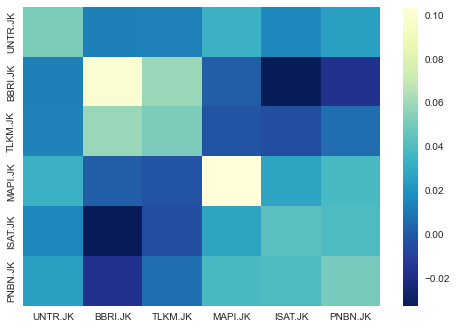

In [307]:
sortIx=getQuasiDiag(HRP(sample_ret).link)
sortIx=HRP(sample_ret).corr.index[sortIx].tolist()
sns.heatmap(sample_corr.loc[sortIx, sortIx], cmap='YlGnBu_r')

In [308]:
getHRP(sample_ret)

/var/folders/mr/29v91m2x65xbxjv6gbvs3s600000gn/T/ipykernel_1447/2968485359.py:21: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link=sch.linkage(dist, 'single')


UNTR.JK   0.2704
BBRI.JK   0.0706
TLKM.JK   0.1295
MAPI.JK   0.1426
ISAT.JK   0.1977
PNBN.JK   0.1891
dtype: float64

No handles with labels found to put in legend.


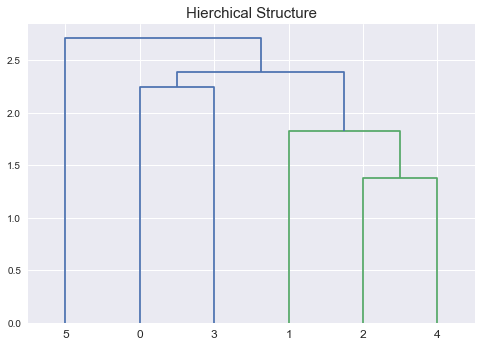

In [326]:
plt.title('Hierchical Structure', fontsize=15)
plt.legend()
cond_assets_dist = pairwise_distances(sample_ret.T)
dend = dendrogram(linkage(cond_assets_dist, method='single'), count_sort=True)

<AxesSubplot:title={'center':'Distance Matrix'}>

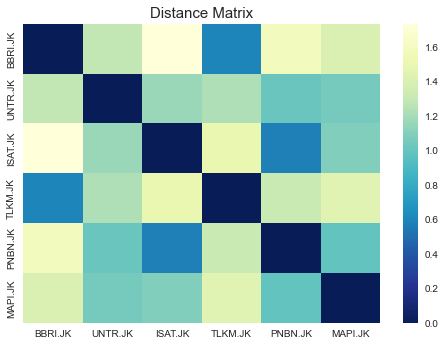

In [327]:
plt.title('Distance Matrix', fontsize=15)
sns.heatmap(dist_matrix(sample_ret), cmap='YlGnBu_r')

No handles with labels found to put in legend.


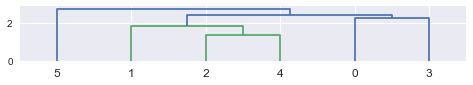

In [328]:
plt.figure(figsize=(8, 1))  
plt.legend()
cond_assets_dist = pairwise_distances(sample_ret.T)
dend = dendrogram(linkage(cond_assets_dist, method='single'), count_sort=False)

# **Markowitz Optimisation**

In [237]:
rng = np.random.default_rng(seed=4567)

class ReturnRes:
    def __init__(self, port, weights):
        self.port = port
        self.weights = weights
        
def monte_carlo_optimise (_assets, num_port):
    rf_rate = rate_bond.mean()  # Average risk-free rate in Indonesia from average return of gov't bonds
    assets_sel = _assets
    ret_assets = ret[assets_sel.index]
    mean_ret = ret_assets.mean()
    exp_ret_assets = assets_sel['EMA-300 Return']
    _real_ret = real_ret[assets_sel.index]
    ewm_cov = ret_assets.ewm(span=300).cov()
    cov = ewm_cov.loc[ewm_cov.index.levels[0][-1]]
    num_assets = len(assets_sel.index)
    num_portfolios = num_port
    rand_weights = rng.random(size=(num_portfolios, num_assets))
    _weights = pd.DataFrame((rand_weights.T / rand_weights.sum(axis=1)).T, columns=assets_sel.index).round(3)
    p_ret =mean_ret.dot(_weights.T)*252
    p_real_ret = _weights.dot(_real_ret)
    p_exp_ret = _weights.dot(exp_ret_assets)
    p_vol =_weights.apply(lambda row: np.sqrt(row.T@cov@row), axis=1)*np.sqrt(252)
    p_premium =p_exp_ret - rf_rate
    p_sharpe =p_premium / (p_vol)
    p_weights = _weights.copy()
    p_weights.columns = pd.MultiIndex.from_product([_weights, ['Weights']])
    port_metrics = pd.DataFrame({'Annualised Return':p_ret,'Expected Return':p_exp_ret, 'Realised Return':p_real_ret, 'Volatility':p_vol,
                                    'Sharpe' :p_sharpe})
    portfolios = port_metrics.copy()
    portfolios[p_weights.columns]  = p_weights
    print('Metrics from {}'.format(training_year))
    
    return ReturnRes(port=portfolios, weights=_weights)

def equal_weights_port (_assets):
    rf_rate = rate_bond.mean()  # Average risk-free rate in Indonesia from average return of gov't bonds
    assets_sel = _assets
    ret_assets = ret[assets_sel.index]
    mean_ret = ret_assets.mean()
    exp_ret_assets = assets_sel['EMA-300 Return']
    _real_ret = real_ret[assets_sel.index]
    ewm_cov = ret_assets.ewm(span=300).cov()
    cov = ewm_cov.loc[ewm_cov.index.levels[0][-1]]
    num_assets = len(assets_sel.index)
    test_weights_equal = np.ones(num_assets).round(2)*(1/num_assets)
    _weights = pd.Series(test_weights_equal, index=assets_sel.index)
    p_ret =mean_ret.dot(_weights)*252
    p_real_ret = _real_ret.dot(_weights)
    p_exp_ret = exp_ret_assets.dot(_weights)
    p_vol =np.sqrt(_weights.T.dot((cov).dot(_weights)))*np.sqrt(252)
    p_premium =p_exp_ret -rf_rate
    p_sharpe =p_premium / (p_vol)
    port_metrics = pd.Series({'Annualised Return':p_ret,'Expected Return':p_exp_ret, 'Realised Return':p_real_ret, 
                              'Volatility':p_vol, 'Sharpe' :p_sharpe, 'Stocks':'Weights'})
    portfolios = port_metrics.copy()
    print('Metrics from {}'.format(training_year))
    
    return ReturnRes(port=portfolios, weights=_weights)


def HRP_port (_assets):
    rf_rate = rate_bond.mean()  # Average risk-free rate in Indonesia from average return of gov't bonds
    assets_sel = _assets
    ret_assets = ret[assets_sel.index]
    mean_ret = ret_assets.mean()
    exp_ret_assets = assets_sel['EMA-300 Return']
    _real_ret = real_ret[assets_sel.index]
    ewm_cov = ret_assets.ewm(span=300).cov()
    cov = ewm_cov.loc[ewm_cov.index.levels[0][-1]]
    _weights = getHRP(ret_assets)
    p_ret =mean_ret.dot(_weights)*252
    p_real_ret = _real_ret.dot(_weights)
    p_exp_ret = exp_ret_assets.dot(_weights)
    p_vol =np.sqrt(_weights.T.dot((cov).dot(_weights)))*np.sqrt(252)
    p_premium =p_exp_ret - rf_rate
    p_sharpe =p_premium / (p_vol)
    #p_weights = _weights.copy()
    port_metrics = pd.Series({'Annualised Return':p_ret,'Expected Return':p_exp_ret, 'Realised Return':p_real_ret, 
                              'Volatility':p_vol, 'Sharpe' :p_sharpe, 'Stocks':'Weights'})
    portfolios = port_metrics.copy()
    #portfolios=portfolios.append(_weights)
    print('Metrics from {}'.format(training_year))

    return ReturnRes(port=portfolios, weights=_weights)

def min_volatility(portfolios):
    port = portfolios.port
    w = portfolios.weights
    idx=port['Volatility'].idxmin()
    return ReturnRes(port=port.iloc[idx], 
                     weights=w.iloc[idx])

def optimal_risk(portfolios):
    port = portfolios.port
    w = portfolios.weights
    idx = port['Sharpe'].idxmax()
    return ReturnRes(port=port.iloc[idx], 
                     weights=w.iloc[idx])


def plot_summarise(portfolios, Y ='Expected Return', X = 'Volatility', plot_opt=True, plot_min=False, plot_alpha=False):
    portfolio = portfolios.port
    plt.subplots(figsize=(10, 8))
    plt.scatter(portfolio[X], portfolio[Y], c= portfolio['Sharpe'],cmap='magma', marker='.', s=10, alpha=0.3)
    plt.colorbar().set_label('Sharpe')
    plt.xlabel(X)
    plt.ylabel(Y)
    
    if plot_opt==True:
        optimal_risky_port=optimal_risk(portfolios).port
        plt.scatter(optimal_risky_port[X], optimal_risky_port[Y], color='g', marker='^', s=200, label = 'Optimal Risky Portfolio - Maximum Sharpe Ratio')
    if plot_min==True:
        min_vol_port =min_volatility(portfolios).port
        plt.scatter(min_vol_port[X], min_vol_port[Y], color='r', marker='^', s=200, label= 'Minimum Volatility Portfolio')
    else:
        pass
    
    plt.legend(labelspacing=0.8, loc='lower left')
    plt.show()
    
def print_port(portfolios):
    portfolio = portfolios.port
    min_vol_port =min_volatility(portfolios).port
    optimal_risky_port=optimal_risk(portfolios).port
    print('-'*10)
    print('Optimally Risky Portfolio')
    print('-'*10)
    print(optimal_risky_port)
    print('-'*10)
    print('-'*10)
    print('Minimal Risk Portfolio')
    print('-'*10)
    print(min_vol_port)
    print('-'*10)

In [238]:
rand_assets = assets.sort_values(by='EMA-300 Return', ascending=False).head(5).sample(n=3)
num_port=5000

Metrics from 2019


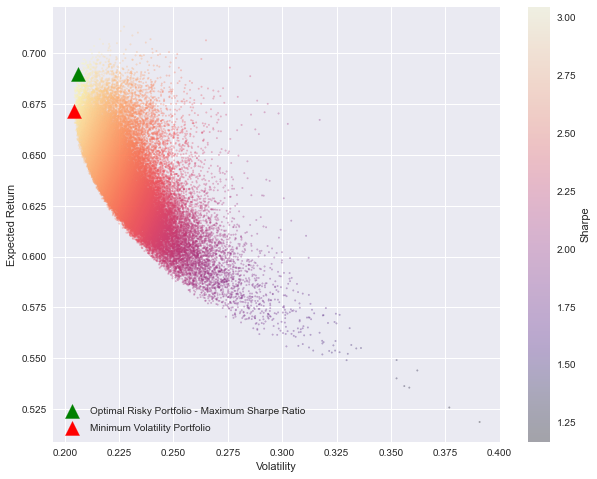

In [292]:
ran_port = monte_carlo_optimise(sample_ret.T, num_port=50000)
ran_port.port

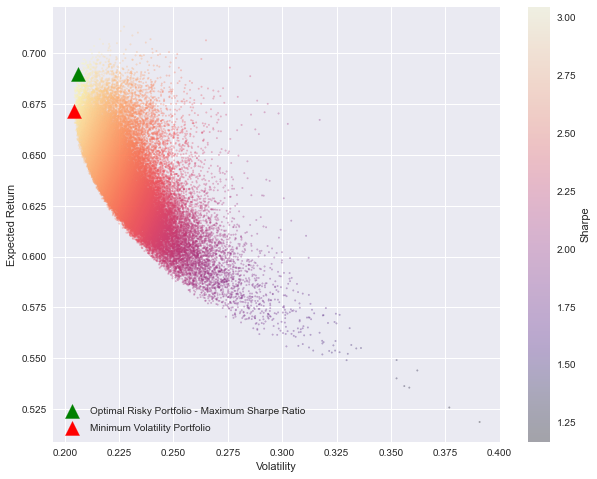

In [301]:
plot_summarise(ran_port, plot_min=True)

In [241]:
# import matplotlib.animation as animation

# portfolio = ran_port.port
# fig, ax = plt.subplots(figsize=(10, 8))

# def animate(i):
#     fig.clear()
#     ax = fig.add_subplot(111, aspect='equal', autoscale_on=False, xlim=(0, 1), ylim=(0, 1))
#     ax.set_xlim(0,1)
#     ax.set_ylim(0,1)
#     ax.set_xlabel(X)
#     ax.set_ylabel(Y)
#     s=ax.scatter(portfolio['Volatility'].iloc[:i], portfolio['Expected Return'].iloc[:i],
#                  c= portfolio['Sharpe'].iloc[:i],
#                  cmap='magma', marker='.', s=10, alpha=0.3)
#     fig.colorbar(s).set_label('Sharpe')


# anim = animation.FuncAnimation(fig, animate, interval=0.001, frames=range(50000))

# plt.show()

# anim.save('animation.gif', writer = 'Pillow', fps = 5000)

In [242]:
HRP_port(rand_assets).weights

Metrics from 2019


/var/folders/mr/29v91m2x65xbxjv6gbvs3s600000gn/T/ipykernel_1447/2968485359.py:21: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link=sch.linkage(dist, 'single')


MNCN.JK   0.2505
AALI.JK   0.4596
PGAS.JK   0.2899
dtype: float64

# **Testing 2019**

In [243]:
from scipy.stats import norm

def backtest(portfolios, plots=True, test_year=test_year, num_port=500000, initial_inv=1000000000, weights_equal=False, HRP=False):
    pd.options.display.max_rows = None
     
    if weights_equal==True:
        _port = equal_weights_port(portfolios)
        test_weights=_port.weights.values
        _weights=test_weights
    elif HRP==True:
        _port = HRP_port(portfolios)
        test_weights=_port.weights.values
        _weights=test_weights    
    else:
        rand_portfolios = monte_carlo_optimise(portfolios, num_port)
        optimal_risk_port = optimal_risk(rand_portfolios)
        _port = optimal_risk_port
        test_weights = _port.weights.values
        _weights = test_weights
        plot_summarise(rand_portfolios,plot_min=True)
        
    display(_port.port)
    display(_port.weights)
    _port_assets = portfolios
    _num_assets = len(_port_assets)
    test_yr = test_year #Training year + 1 year
    end_yr = f'{int(test_yr)+1}' #Test year + 1 year
    rf_rate = rate_bond.mean()
    
    # Get price data
    port_close_price = close_price_all[_port_assets.index]
    test_close=port_close_price.loc[test_yr:end_yr]
    test_ret = (test_close.iloc[-1] / test_close.iloc[0]) - 1
    test_ret_pct = test_ret
    ret_port_asset=log_rate(test_close).dropna()
    
    # Get unweighted mean and cov
    mean_ret_port=ret_port_asset.mean()
    cov_ret_port =ret_port_asset.cov()
    semicov_ret_port = ret_port_asset[ret_port_asset < 0].cov()
    
    # Calculate returns
    holding_ret_port = test_ret_pct.dot(_weights)
    log_rets = ret_port_asset.dot(_weights)
    port_cum = log_rets.sum()
    log_rets_cum = log_rets.cumsum().ffill()
    max_drawdown = log_rets_cum.min()
    
    # Get monthly and yearly returns
    mon_rets = log_rets.resample('M').sum()
    quarter_rets = log_rets.resample('Q').sum()
    quarter_rets.index = quarter_rets.index.strftime('%m/%Y')
    mon_rets.index = mon_rets.index.strftime('%m/%Y')
    
    # Get weighted mean and cov
    mean_port = mean_ret_port.dot(_weights)
    stdev_port = np.sqrt(_weights.T.dot(cov_ret_port.dot(_weights)))
    semistdev_port = np.sqrt(_weights.T.dot(semicov_ret_port.dot(_weights)))
    
    # Calculate statitics
    volatility = stdev_port
    downside_risk = semistdev_port
    premium = port_cum - rf_rate
    sharpe = premium / (volatility*np.sqrt(252))
    sortino = premium / (downside_risk*np.sqrt(252))
    skew = log_rets.skew()
    kurt = log_rets.kurt()
    
    investment = initial_inv
    mean_investment = (1+mean_port)*investment
    stdev_investment = stdev_port*investment
    conf = 0.05
    conf2 = 0.01
    conf3 = 0.005
    cutoff1 = norm.ppf(conf, mean_port, stdev_port)
    cutoff2 = norm.ppf(conf2, mean_port, stdev_port)
    cutoff3 = norm.ppf(conf3, mean_port, stdev_port)
    vard1_1 = cutoff1 #-(investment - cutoff1)
    vard1_2 = cutoff2 #-(investment - cutoff2)
    vard1_3 = cutoff3 #-(investment - cutoff3)
    hist_vard1_1=log_rets.sort_values(ascending=True).quantile(q=0.05)#*investment
    hist_vard1_2=log_rets.sort_values(ascending=True).quantile(q=0.01)#*investment
    hist_vard1_3=log_rets.sort_values(ascending=True).quantile(q=0.005)#*investment
    res=pd.Series({'Holding Return': holding_ret_port, 'Cumulative Return': port_cum, 'Annualised Volatility': volatility*np.sqrt(252), 'Annualised Downside Risk':downside_risk*np.sqrt(252),
                   'Max Drawdown':max_drawdown,'Ex-Post Sharpe': sharpe, 'Ex-Post Sortino': sortino, 'Skew': skew, 'Kurtosis':kurt,  
                   'Parametric 1-day Value-at-Risk (95% C.L.)': vard1_1, 'Parametric 1-day Value-at-Risk (99% C.L.)': vard1_2, 'Parametric 1-day Value-at-Risk (99.5% C.L.)': vard1_3,
                   'Historical 1-day Value-at-Risk (95% C.L.)': hist_vard1_1, 'Historical 1-day Value-at-Risk (99% C.L.)': hist_vard1_2, 'Historical 1-day Value-at-Risk (99.5% C.L.)': hist_vard1_3})
    
    #Plots
    if plots==True:
        fig1, ax1 = plt.subplots(2, 1, figsize=(12,10))
        log_rets.plot(kind='hist', bins=50, title='Portfolio Return Distribution', ax=ax1[0])
        log_rets.plot(kind='kde', title='Portfolio Return Density', ax=ax1[1])
        fig2, ax2 = plt.subplots(1,2,figsize=(12,5))
        mon_rets.plot(kind='barh', ax=ax2[0], title= 'Monthly Returns')
        quarter_rets.plot(kind='barh', ax=ax2[1], title= 'Quarterly Returns')
        fig3, ax3 = plt.subplots(figsize=(12,5))
        df = log_rets_cum
        df.plot(title='Cumulative Rate of Return on Portfolio', ax=ax3)
        plt.fill_between(df.index, 0, df.values, where=df<0, interpolate=True, color='r')
        plt.fill_between(df.index, 0, df.values, where=df>0, interpolate=True, color='g')
        fig4, ax4 = plt.subplots(figsize=(12,5))
        df2 = log_rets.clip(upper=0)
        df2.plot(title='Underwater Plot',ax=ax4, color='r')
        plt.fill_between(df2.index, 0, df2.values, where=df2<0, interpolate=True, color='r')
        plt.ylim(top=0)
        plt.show()
        pd.set_option("display.max_rows", 20)
        
    print('--------------------------------')
    print('--------------------------------') 
    print('Metrics from {} - {}'.format(test_yr,end_yr))
    display(res.apply(lambda x: '%.3f' % x))
    return res

In [ ]:
print('Run Simulation? yes/no')
ask = input()
if ask == 'no':
    raise UserWarning('Early Exit: Continue to Simulation')
else:
    pass

## **Random Assets Portfolio + Equal Weights**

In [ ]:
rand_assets_5 = assets.sample(n=5)
rand_assets_10 = assets.sample(n=10)
rand_assets_15 = assets.sample(n=15)

In [ ]:
pd.Series(rand_assets_10.index).to_clipboard()

In [ ]:
rand_5_ew=backtest(rand_assets_5, plots=True, weights_equal=True)

In [ ]:
rand_10_ew=backtest(rand_assets_10, weights_equal=True)

In [ ]:
rand_15_ew=backtest(rand_assets_15, weights_equal=True)

## **Random Assets Portfolio + Optimised**

In [ ]:
rand_5_mvo=backtest(rand_assets_5)

In [ ]:
rand_10_mvo=backtest(rand_assets_10)

In [ ]:
rand_15_mvo=backtest(rand_assets_15)

In [ ]:
rand_15_mvo.to_clipboard()

## **Random Assets Portfolio + HRP**

In [ ]:
rand_5_hrp=backtest(rand_assets_5, HRP=True)

In [ ]:
rand_10_hrp=backtest(rand_assets_10, HRP=True)

In [ ]:
rand_15_hrp=backtest(rand_assets_15, HRP=True)

## **Clustered Assets Portfolio + Equal Weights** 

In [ ]:
#backtest(kmeans_portfolio, weights_equal=True)
cluster_method= assets_cluster
cluster_mean = kmeans_mean
cluster_kmeans_ew = pd.DataFrame()
for cluster in cluster_mean.index:
    portf=cluster_method[cluster_method['Cluster Group']==cluster]
    print('---------------------------------')
    print('---------------------------------')
    print('Portfolio Cluster:',cluster)
    print('---------------------------------')
    print('---------------------------------')
    cluster_kmeans_ew[cluster]=backtest(portf, weights_equal=True)

In [ ]:
cluster_kmeans_ew

In [ ]:
# backtest(agg_portfolio, weights_equal=True)
cluster_method= assets_cluster_agg
cluster_mean = agg_cluster_mean
cluster_agg_ew = pd.DataFrame()
for cluster in cluster_mean.index:
    portf=cluster_method[cluster_method['Cluster Group']==cluster]
    print('---------------------------------')
    print('---------------------------------')
    print('Portfolio Cluster:',cluster)
    print('---------------------------------')
    print('---------------------------------')
    cluster_agg_ew[cluster]=backtest(portf, weights_equal=True)

In [ ]:
cluster_agg_ew

## **Clustered Assets Portfolio + Optimised** 

In [ ]:
cluster_kmeans_mvo=backtest(kmeans_portfolio)
# cluster_method= assets_cluster
# cluster_mean = kmeans_mean
# cluster_kmeans_mvo = pd.DataFrame()
# for cluster in cluster_mean.index:
#     portf=cluster_method[cluster_method['Cluster Group']==cluster]
#     print('---------------------------------')
#     print('---------------------------------')
#     print('Portfolio Cluster:',cluster)
#     print('---------------------------------')
#     print('---------------------------------')
#     cluster_kmeans_mvo[cluster]=backtest(portf, num_port=500000)

In [ ]:
cluster_agg_mvo=backtest(pca_portfolio)
# cluster_method= assets_cluster_agg
# cluster_mean = agg_cluster_mean
# cluster_agg_mvo = pd.DataFrame()
# for cluster in cluster_mean.index:
#     portf=cluster_method[cluster_method['Cluster Group']==cluster]
#     print('---------------------------------')
#     print('---------------------------------')
#     print('Portfolio Cluster:',cluster)
#     print('---------------------------------')
#     print('---------------------------------')
#     cluster_agg_mvo[cluster]=backtest(portf, num_port=500000)

## **Clustered Assets Portfolio + HRP** 

In [ ]:
cluster_kmeans_hrp=backtest(kmeans_portfolio, HRP=True)
# cluster_method= assets_cluster
# cluster_mean = kmeans_mean
# cluster_kmeans_hrp = pd.DataFrame()
# for cluster in cluster_mean.index:
#     portf=cluster_method[cluster_method['Cluster Group']==cluster]
#     print('---------------------------------')
#     print('---------------------------------')
#     print('Portfolio Cluster:',cluster)
#     print('---------------------------------')
#     print('---------------------------------')
#     cluster_kmeans_hrp[cluster]=backtest(portf, HRP=True)

In [ ]:
cluster_agg_hrp=backtest(pca_portfolio, HRP=True)
# cluster_method= assets_cluster_agg
# cluster_mean = agg_cluster_mean
# cluster_agg_hrp = pd.DataFrame()
# for cluster in cluster_mean.index:
#     portf=cluster_method[cluster_method['Cluster Group']==cluster]
#     print('---------------------------------')
#     print('---------------------------------')
#     print('Portfolio Cluster:',cluster)
#     print('---------------------------------')
#     print('---------------------------------')
#     cluster_agg_hrp[cluster]=backtest(portf, HRP=True)

## **Market Portfolio**

In [ ]:
market_test = df2['Close'][test_year:f'{int(test_year)+1}']
market_hold_ret = (market_test.iloc[-1] / market_test[0]) -1 
market_log_ret = log_rate(market_test).cumsum().ffill()
print('Market Holding Return')
market_hold_ret

In [ ]:
# market_log_ret

In [ ]:
market_log_ret.plot(title='Market Cumulative Rate of Return 2021', figsize=(12,5))

In [ ]:
df5 = market_log_ret
df5.plot(title='Cumulative Rate of Return on Portfolio', figsize=(12,5))
plt.fill_between(df5.index, 0, df5.values, where=df5<0, interpolate=True, color='r')
plt.fill_between(df5.index, 0, df5.values, where=df5>0, interpolate=True, color='g')

In [ ]:
print('Market Cumulative Return')
market_log_ret.iloc[-1]

In [ ]:
mean_port = market_log_ret.mean()
stdev_port = market_log_ret.std()
max_drawdown = market_log_ret.min()
volatility = stdev_port*np.sqrt(252)
sharpe = (market_hold_ret) / (volatility)
skew = market_log_ret.skew(axis=0)
kurt = market_log_ret.kurt(axis=0)
conf = 0.05
conf2 = 0.01
conf3 = 0.005
cutoff1 = norm.ppf(conf, mean_port, stdev_port)
cutoff2 = norm.ppf(conf2, mean_port, stdev_port)
cutoff3 = norm.ppf(conf3, mean_port, stdev_port)
vard1_1 = cutoff1 #-(investment - cutoff1)
vard1_2 = cutoff2 #-(investment - cutoff2)
vard1_3 = cutoff3 #-(investment - cutoff3)
hist_vard1_1=market_log_ret.sort_values(ascending=True).quantile(q=0.05)#*investment
hist_vard1_2=market_log_ret.sort_values(ascending=True).quantile(q=0.01)#*investment
hist_vard1_3=market_log_ret.sort_values(ascending=True).quantile(q=0.005)#*investment
res=pd.Series({'Holding Return': market_hold_ret, 'Cumulative Return': market_log_ret.iloc[-1], 'Annualised Volatility': volatility, 'Max Drawdown':max_drawdown, 'Sharpe': sharpe, 'Skew': skew, 'Kurtosis':kurt,  
               'Parametric 1-day Value-at-Risk (95% C.L.)': vard1_1, 'Parametric 1-day Value-at-Risk (99% C.L.)': vard1_2, 'Parametric 1-day Value-at-Risk (99.5% C.L.)': vard1_3,
               'Historical 1-day Value-at-Risk (95% C.L.)': hist_vard1_1, 'Historical 1-day Value-at-Risk (99% C.L.)': hist_vard1_2, 'Historical 1-day Value-at-Risk (99.5% C.L.)': hist_vard1_3})
display(res.apply(lambda x: '%.3f' % x))

market_metrics= res


In [ ]:
market_metrics.to_clipboard()